---
<div align="center">

# ML2 | Classificação de Sons Urbanos
</div>

---


### Contexto

``Classificação de Sons`` é considerada uma das tarefas mais importantes no campo de **deep learning**. Tem grande impacto em aplicações de **reconhecimento de voz** em assistentes virtuais (como Siri ou Alexa), **atendimento ao cliente**, bem como em **sistemas de recomendação de música e mídia**. Além disso, também influencia na área médica para detectar anomalias em batimentos cardíacos ou sons respiratórios. Além disso, é utilizada em **sistemas de segurança e vigilância** para ajudar a detectar e avaliar possíveis incidentes dentro de uma residência, como pedidos de socorro, disparos ou vidros quebrando. Portanto, nosso objetivo é desenvolver **algoritmos de deep learning** que nos permitam classificar corretamente alguns sons ambientais fornecidos pelo dataset ``UrbanSound8k``.

### Abordagem de Resolução

Utilizando o dataset ``UrbanSound8k`` como nossa fonte principal de dados, pretendemos projetar modelos de deep learning capazes de **identificar**, **prever** e **avaliar** diversos sons comuns em ambientes urbanos, apoiando aplicações em monitoramento de ruído, segurança pública e análise ambiental, permitindo **avaliação precisa** e resposta a eventos sonoros em ambientes urbanos.

### Plano

O projeto inclui várias fases-chave, incluindo:

1. ``Análise Exploratória de Dados``: Começamos analisar o dataset UrbanSound8k para entender melhor sua **estrutura e conteúdo** e a distribuição das classes sonoras.
2. ``Pré-processamento de Dados``: **Limpeza e preparação das amostras de áudio** para garantir consistência e qualidade.
3. ``Engenharia de Features``: Utilizar a biblioteca **Librosa**, extraímos **features relevantes** dos áudios, como as **coeficientes MFCC (Mel-frequency cepstral coefficients)**.
4. ``Definição de Arquitetura de Modelos``: Desenvolvemos arquiteturas de redes neurais adequadas para classificação de som, experimentando diferentes modelos de deep learning.
5. ``Treinamento e Avaliação de Desempenho``: Empregando validação cruzada com 10 folds no dataset pre-particionado para avaliar o desempenho dos modelos usando métricas como acurácia e matrizes de confusão.
6. ``Inferência Estatística``: Realizar uma avaliação estatística das diferenças de desempenho entre os modelos desenvolvidos.

<div align="center">
    
---
## Importar dataset
---

</div>

In [ ]:
"""

!pip install tensorflow==2.18.0 tensorflow_intel==2.18.0 tf_keras==2.18.0
!pip install keras==3.6.0
!pip install tensorflow-hub==0.16.1
!pip install numpy==1.26.4 scipy==1.12.0 pandas==2.2.3
!pip install librosa==0.10.2.post1 soundfile soxr
!pip install scikit-learn==1.5.2 seaborn matplotlib
!pip install tensorboard==2.18.0 tensorboard-data-server==0.7.2
!pip install audiomentations==0.37.0
!pip install scikit-posthocs
"""
"""
# Soundata instala automaticamente a versão compatível de librosa
!pip install soundata
"""


'\n# TensorFlow 2.15 compatível com Python 3.10\n!pip install tensorflow==2.15.0 keras==2.15.0 tensorflow-hub==0.16.1\n\n# Pacotes de suporte\n!pip install numpy==1.24.3 pandas==1.5.3 scipy==1.10.1\n\n# Soundata instala automaticamente a versão compatível de librosa\n!pip install soundata\n'

In [2]:

import soundata

dataset = soundata.initialize("urbansound8k", data_home="E:/iacd/3ano/AC2")
print(dataset.data_home)

"""
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

"""

E:/iacd/3ano/AC2


'\ndataset.download()  # download the dataset\ndataset.validate()  # validate that all the expected files are there\n\nexample_clip = dataset.choice_clip()  # choose a random example clip\nprint(example_clip)  # see the available data\n\n'

<div align="center">
    
---
## Importar bibliotecas
---

</div>

In [1]:
# Remove Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
import pandas as pd
import librosa as libr

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras import regularizers
import tensorflow_hub as hub
from scipy.stats import (friedmanchisquare)

from Utils.Configuration import (loadConfig, loadPathsConfig)

from DataPreProcessing.AudioManagement import (loadAudio, showcaseAudio)
from DataPreProcessing.FeatureExtraction import (extractAllRawFeatures, extractRawFeatures1D, extractRawFeatures2D, processRawFeatures, extractMFCCs)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotFeatureDistributionByFold, plotAudioWave, plotAudio1DimensionalFeature, plotChromaFeatures, plotMelSpectrogram, plotSpectralContrast)

from ModelDevelopmentAndEvaluation.MLP import (MLP)
from ModelDevelopmentAndEvaluation.CNN import (CNN)
from ModelDevelopmentAndEvaluation.ResNet import (ResNet)
from ModelDevelopmentAndEvaluation.transferLearning import (createEmbeddingsFaster, createTransferLearning)
from ModelDevelopmentAndEvaluation.UrbanSound8kManager import (UrbanSound8kManager)
from ModelDevelopmentAndEvaluation.DataVisualization import (plotNetworkTrainingPerformance, plotScatterClass, plotCritialDifferenceDiagram)

In [4]:
import sys
print(sys.executable)

C:\Users\2ndni\anaconda3\envs\tensorflow\python.exe


In [5]:
# Load Configuration Dictionaries
config = loadConfig()
pathsConfig = loadPathsConfig()
config

{'DURATION': 4,
 'SAMPLE_RATE': 44100,
 'HOP_LENGTH': 551,
 'WINDOW_LENGTH': 1014,
 'N_FFT': 1024,
 'TIME_SIZE': 321,
 'N_CHROMA': 12,
 'N_MFCC': 13}

<div align="center">
    
---
## Análise Exploratória de Dados
---

</div>

Nesta fase inicial do projeto, planejamos **revisar e analisar os dados** presentes no dataset UrbanSound8k. Nosso objetivo é obter melhores percepções não apenas sobre os dados disponíveis, mas também sobre **técnicas de processamento eficazes** que nos ajudem a preparar os dados para o treinamento dos modelos.

In [6]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')

df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

O dataset fornece principalmente a ``metadata`` sobre as amostras de áudio, incluindo detalhes como o **nome do arquivo** (*slice_file_name*) e os **timestamps de início e fim** (*start* e *end*) no **ID do áudio original** (*fsID*). Além disso, inclui informações sobre o **fold** ao qual cada amostra pertence e o **rótulo** correspondente que a classifica em uma das classes-alvo predefinidas.

Como muito do dataset compreende detalhes técnicos relacionados ao processamento de áudio, nosso foco será analisar a **distribuição dos rótulos alvo no dataset**, uma etapa crucial para entender o **(des)balanceamento de classes** e assegurar que os modelos sejam treinados adequadamente.

## Extração e Pré-processamento dos Dados


---
### Análise e Exploração das Características dos Dados
---


In [ ]:
# Load a audio
audioName = '101415-3-0-2.wav'
audioData = loadAudio(df_audio=df, audioSliceName=audioName, audioDuration=config['DURATION'], targetSampleRate=config['SAMPLE_RATE'], usePadding=True)
audioData.shape

(176400,)

In [ ]:
# Show the audio associated with the selected file
showcaseAudio(df_audio=df, audioSliceName=audioName)

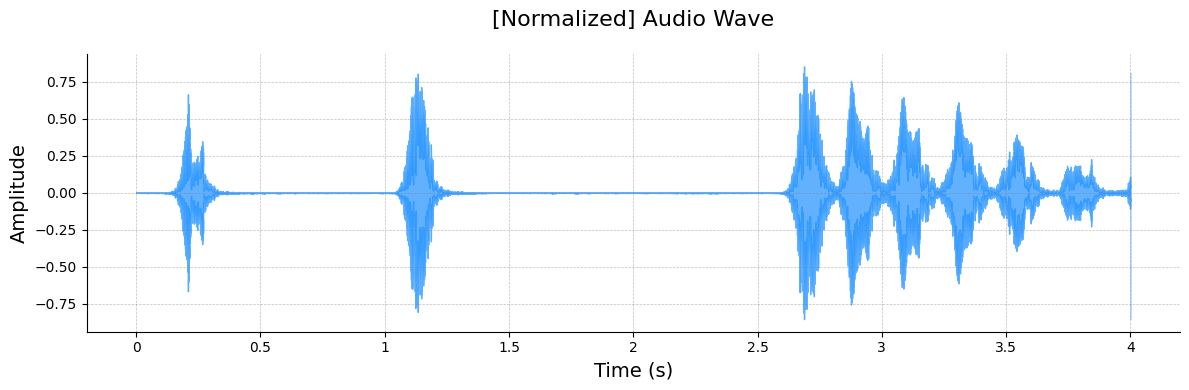

In [ ]:
# Plot the Audio Wave
plotAudioWave(df_audio=df, audioSliceName=audioName, config=config)

---
### Características Unidimensionais (1-D)
---

#### &rarr; Zero-Crossing Rate (ZCR)

``Descrição`` : ZCR mede o quão **comum são as mudanças de sinal** (quando passa zero) num frame.

Esta característica que pertence ao **domínio temporal** é útil para **distinguir entre tipos de ruído or sons impulsivos diferentes**, tal como buzinas de carros ou latidos de cães, que têm comportamentos temporais diferentes.

In [ ]:
# Compute the Audio's Zero Crossing Rate
zeroCrossingRate = libr.feature.zero_crossing_rate(y=audioData)
print(zeroCrossingRate.shape)
# zeroCrossingRate

(1, 345)


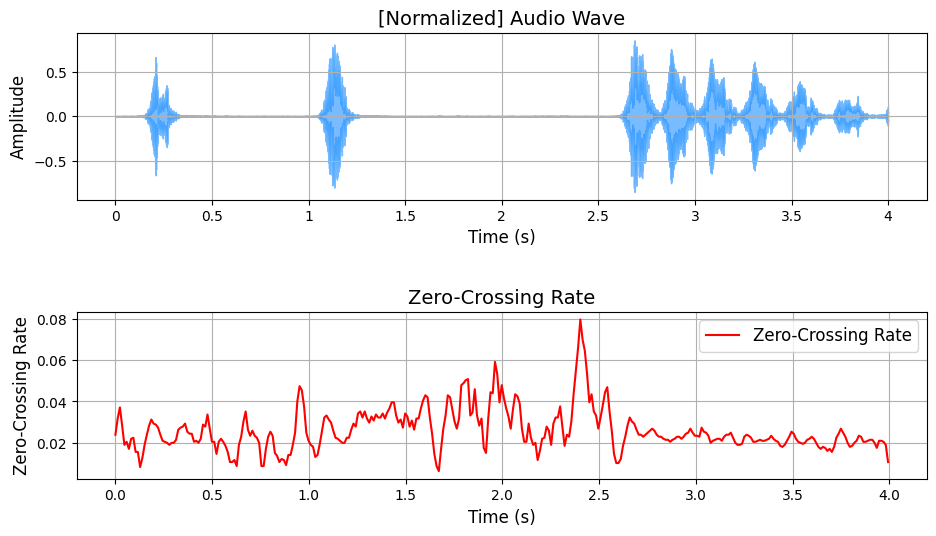

In [ ]:
# Plot the Audio's Zero-Crossing Rate
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=zeroCrossingRate, featureName='Zero-Crossing Rate', yLabel='Zero-Crossing Rate', color='r', config=config)

#### &rarr; Spectral Centroid

``Descrição`` : É o "centro de massa" do espectro, dando uma indicação de **onde a energia do som está concentrada**.

Ajuda a **distinguir entre sons com frequências diferentes** (por exemplo, sirenes muito agudas ou sons graves de motores a trabalhar).

In [ ]:
# Compute the Audio's Spectral Centroid
spectralCentroid = libr.feature.spectral_centroid(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralCentroid.shape)
# spectralCentroid

(1, 345)


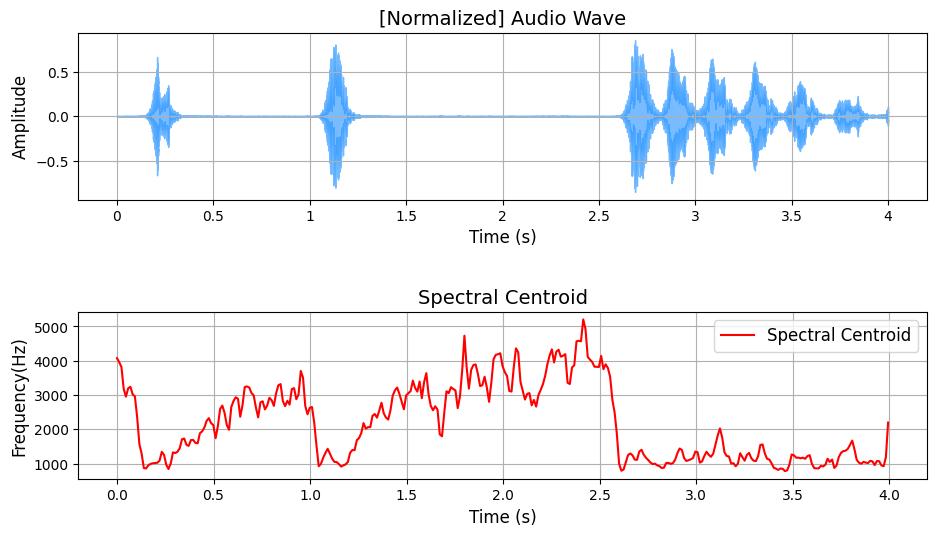

In [ ]:
# Plot the Audio's Spectral Centroid
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralCentroid, featureName='Spectral Centroid', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Bandwidth

``Descrição`` : Esta característica **mede a largura do espectro** (a diferença entre as menores e maiores frequências de um som).

Ajuda a distinguir entre sons com **mudanças de frequência variadas** (por exemplo, ruídos de uma multidão) e sons com **pouca variação** (por exemplo, buzinas ou alarmes).

In [ ]:
# Compute the Audio's Spectral Bandwidth
spectralBandwidth = libr.feature.spectral_bandwidth(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralBandwidth.shape)
# spectralBandwidth

(1, 345)


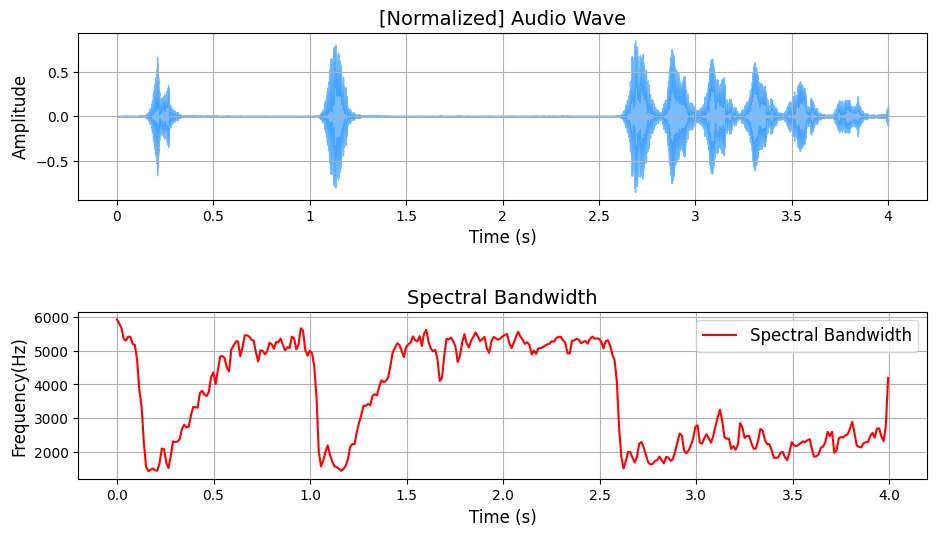

In [ ]:
# Plot the Audio's Spectral Bandwidth
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralBandwidth, featureName='Spectral Bandwidth', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Flatness

``Descrição`` : Mede o quão **barulhento ou tonal um som é, comparando as médias geométrica e aritmética do espectro**.

Ajuda a **distinguir entre sons tonais** (por exemplo, sirenes e buzinas) e **sons barulhentos** (por exemplo, vento e trânsito).

In [ ]:
# Compute the Audio's Spectral Flatness
spectralFlatness = libr.feature.spectral_flatness(y=audioData)
print(spectralFlatness.shape)
# spectralFlatness

(1, 345)


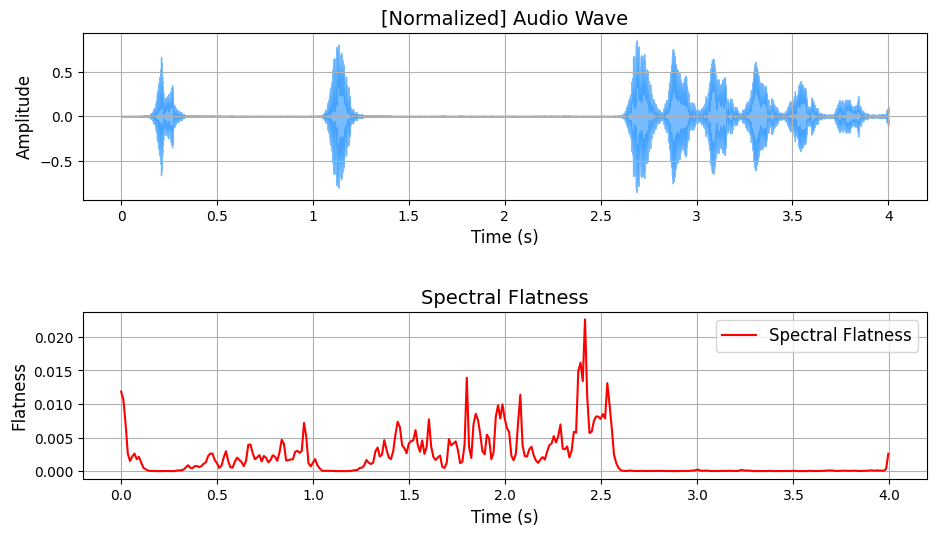

In [ ]:
# Plot the Audio's Spectral Flatness
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralFlatness, featureName='Spectral Flatness', yLabel='Flatness', color='r', config=config)

#### &rarr; Spectral Roll-off

``Descrição`` : É a **frequència abaixo de uma percentagem específica (normalmente 85-90%) na qual a energia espectral total é contida**.

Ajuda a diferenciar entre **sons com frequência alta** (por exemplo, sirenes ou alarmes) e **sons com frequência baixa** (por exemplo, motores a trabalhar).

In [ ]:
# Compute the Audio's Spectral Roll-off
spectralRolloff = libr.feature.spectral_rolloff(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralRolloff.shape)
# spectralRolloff

(1, 345)


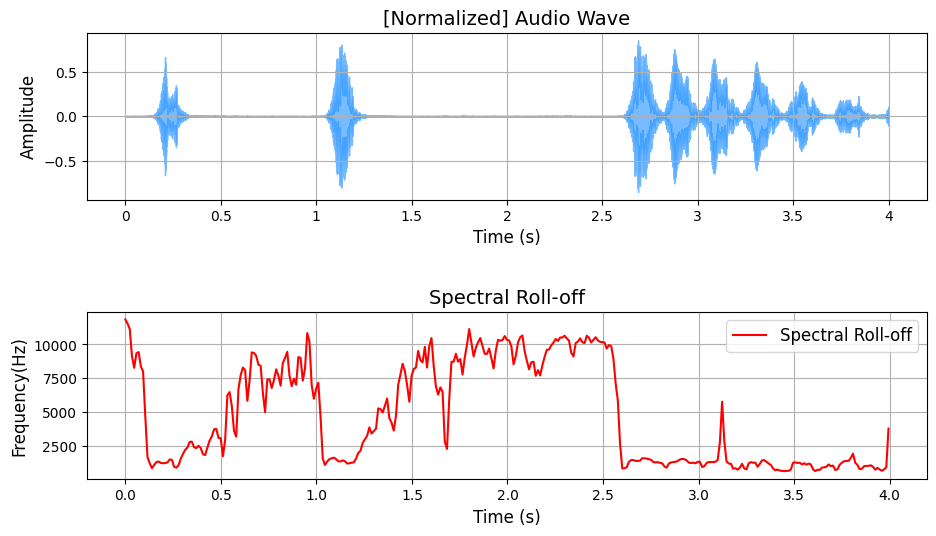

In [ ]:
# Plot the Audio's Spectrall Roll-off
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralRolloff, featureName='Spectral Roll-off', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; RMS Energy

``Descrição`` : É a medição da **energia do sinal ao longo do tempo**.

É útil para distinguir entre **sons ruidosos e silenciosos** e ajuda a **classificar sons com intensidades variadas**, tal como trânsito e ruído de construção.

In [ ]:
# Compute the Audio's RMS Energy
rms = libr.feature.rms(y=audioData)
print(rms.shape)
# rms

(1, 345)


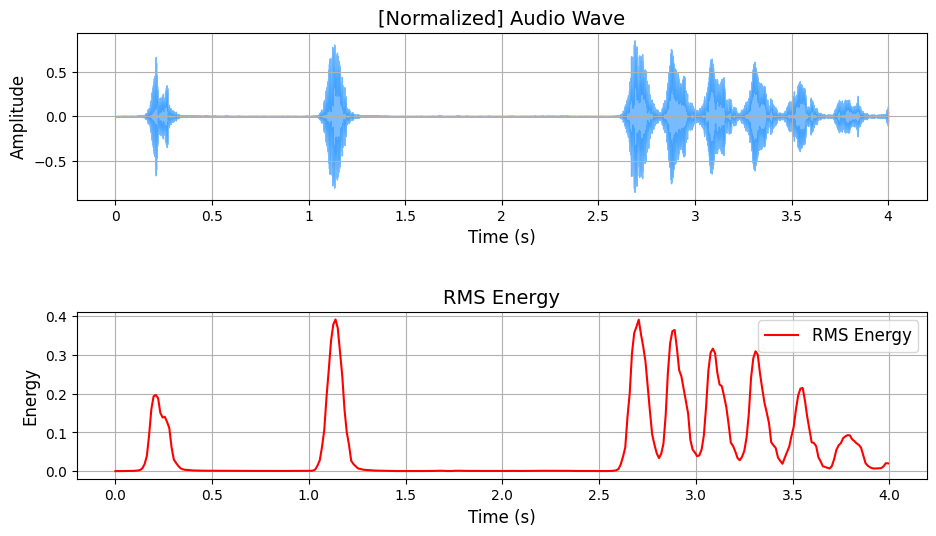

In [ ]:
# Plot the Audio's RMS Energy
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=rms, featureName='RMS Energy', yLabel='Energy', color='r', config=config)

---
### 2-Dimensional Features
---

#### &rarr; Mel-Frequency Cepstral Coefficients (MFCC)

``Descrição`` : MFCCs representam o **espectro de um som a curto prazo**, colocando ênfase nas **características relevantes à audição humana**.

MFCCs são muito usados em **tarefas de classificação de audio**, incluindo reconhecimento de voz e classificação de sons ambientais. Eles **capturam a textura do timbre dos sons**, que é relevante para distinguir sons urbanos de categorias diferentes.

In [ ]:
# Compute the MFC Coefficients
mfccs = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], n_mfcc=config['N_MFCC'])
print(mfccs.shape)
# mfccs

(13, 345)


#### &rarr; Chroma Features (Chroma STFT)

``Descrição`` : Esta característica representa a **classe do nível (Dó, Dó Sustenido, Ré, etc...)** e é útil para identificar **conteúdos tonais e harmoniosos** num audio.

While **chroma features are traditionally more useful for music**, they can capture **harmonic structure in urban sounds**, especially those with tonal elements like sirens or honking.

In [ ]:
# Compute the Chroma Features
chroma_stft = libr.feature.chroma_stft(y=audioData, n_chroma=config['N_CHROMA'], sr=config['SAMPLE_RATE'], n_fft=config['N_FFT'], hop_length=config['HOP_LENGTH'], win_length=config['WINDOW_LENGTH'])
print(chroma_stft.shape)
# chroma_stft

(12, 321)


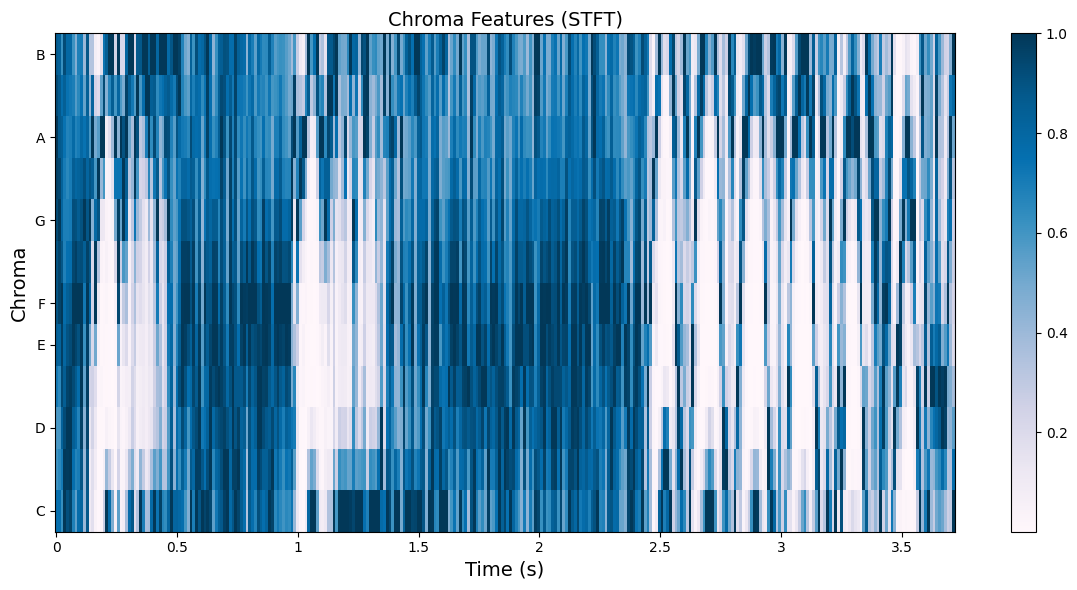

In [ ]:
# Plot the audio's Chroma Features
plotChromaFeatures(audioData=audioData, config=config)

#### &rarr; Mel Spectrogram

``Description`` : A Mel spectrogram is a representation of the **signal's power across different frequencies**, scaled to the **Mel scale** (which mimics human auditory perception).

It is particularly useful for **capturing the overall energy and frequency distribution of urban sounds**. It’s a more detailed version of MFCCs, emphasizing the full frequency range.

In [ ]:
# Compute the Mel Spectrogram
melSpectrogram = libr.feature.melspectrogram(y=audioData, sr=config['SAMPLE_RATE'])
print(melSpectrogram.shape)
# melSpectrogram

(128, 345)


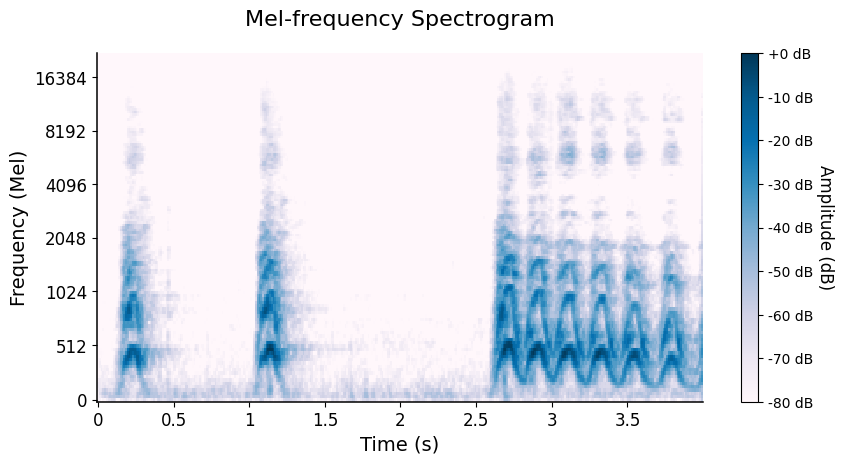

In [ ]:
# Plot the Mel Spectrogram
plotMelSpectrogram(audioData, config['SAMPLE_RATE'])

#### &rarr; Spectral Contrast

``Description`` : Spectral contrast measures the **difference between peaks and valleys** in the sound spectrum.

Urban sounds tend to have **diverse spectral profiles** (e.g., the contrast between loud car horns and quieter ambient sounds), making **spectral contrast useful for distinguishing between classes**.

In [ ]:
# Compute the Spectral Contrast
spectralContrast = libr.feature.spectral_contrast(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralContrast.shape)
# spectralContrast

(7, 345)


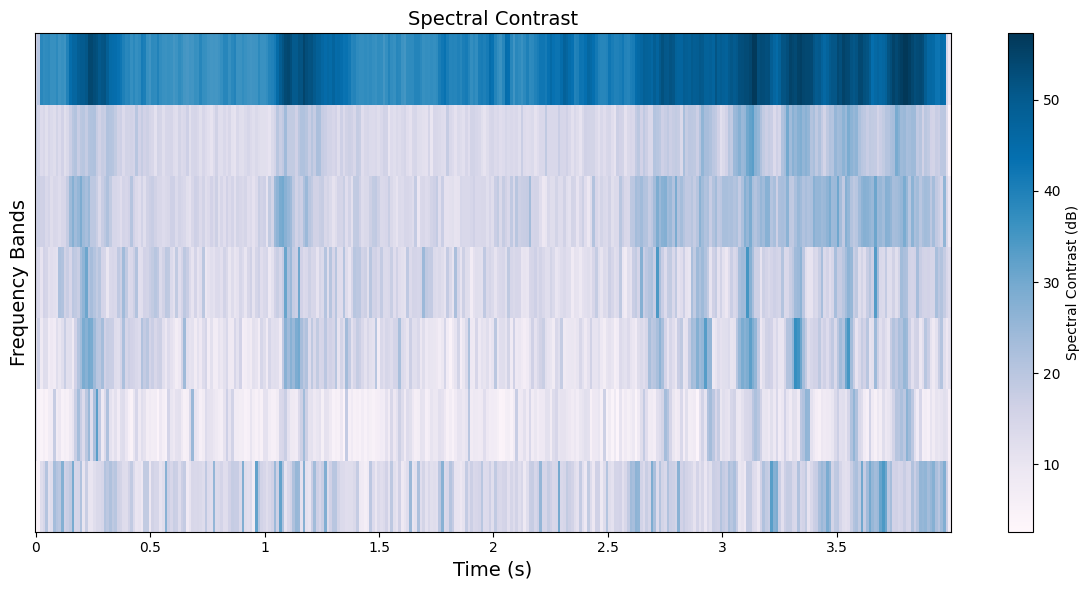

In [ ]:
# Plot the Audio's Spectral Contrast
plotSpectralContrast(audioData=audioData, config=config)

---
## Data Extraction and Processing
---

After **evaluating the various features** that can be extracted from the audio samples, we proceeded with their extraction. For simplicity, although **all these features were extracted into respective datasets**, further **processing was selectively applied to some of them**.

We concentrated on the **one-dimensional features**, aiming to **reduce their complexity and dimensionality** while preserving essential information. To achieve this, we **segmented each audio sample into 25-millisecond windows** and calculated the **mean**, **median**, and **standard deviation** for each feature within these windows, resulting in a total of (*DURATION/SEGMENTATION_WINDOW*) **components per feature**.

For the **two-dimensional features**, we focused exclusively on the **Mel-Frequency Cepstral Coefficients (MFCCs) with 13 components**. We extracted both the **raw MFCCs** and processed versions by computing the mean of each MFCC across time. This approach **reduced data dimensionality**, making it more suitable for **training simpler neural networks**.

In [8]:
# Extract all the 1-Dimensional and 2-Dimensional Features on each Fold
for fold in range(1, 11):

    print(f"[CURRENT] Fold {fold}")
    
    # Extract all Raw Features
    extractAllRawFeatures(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)

    # Extract and process 1-Dimensional Features
    extractRawFeatures1D(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    processRawFeatures(fold=fold, intervalStep=20, featuresDimensionality="1D", pathsConfig=pathsConfig)
    
    # Extract and process 2-Dimensional Features
    extractRawFeatures2D(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    processRawFeatures(fold=fold, intervalStep=20, featuresDimensionality="2D", pathsConfig=pathsConfig)

    # Extract the MFCCs (Raw and their mean based on the coefficients)
    extractMFCCs(audio_df=df, raw=True, fold=fold, config=config, pathsConfig=pathsConfig)
    extractMFCCs(audio_df=df, raw=False, fold=fold, config=config, pathsConfig=pathsConfig)

    print(f"[Fold {fold}] Finished Extraction and Processessing")

[CURRENT] Fold 1
[Fold 1] Finished Extraction and Processessing
[CURRENT] Fold 2
[Fold 2] Finished Extraction and Processessing
[CURRENT] Fold 3
[Fold 3] Finished Extraction and Processessing
[CURRENT] Fold 4
[Fold 4] Finished Extraction and Processessing
[CURRENT] Fold 5
[Fold 5] Finished Extraction and Processessing
[CURRENT] Fold 6
[Fold 6] Finished Extraction and Processessing
[CURRENT] Fold 7
[Fold 7] Finished Extraction and Processessing
[CURRENT] Fold 8
[Fold 8] Finished Extraction and Processessing
[CURRENT] Fold 9
[Fold 9] Finished Extraction and Processessing
[CURRENT] Fold 10
[Fold 10] Finished Extraction and Processessing


<div align="center">
    
---
## Model Architecture - Development and Evaluation
---

</div>

In this phase of the project, we aim to **design, implement, and evaluate** various neural network architectures, assessing their **ability to generalize effectively** across the UrbanSound8k dataset using the previously extracted features.

---
### Managing Training Data
---

We started by examining how the data is **organized across the 10 folds** to better understand how to **manage and utilize it effectively**. Given that the evaluation of the models requires a **10-Fold Cross-Validation methodology**, we implemented a systematic approach: **designating one fold as the test set**, the **next fold as the validation set**, and using the **remaining folds for training**, which aligns with the **proposed split and evaluation techniques** described in the **Assignment Paper**.

---
### Architecture Selection (Temos que escolher as redes neuronais)
---

As part of the **assignment requirements**, we will **design and evaluate multiple neural network architectures** to assess their **generalization performance on the UrbanSound8k dataset**. Specifically, we will develop and test the following **network** types:

- ``Multi-Layer Perceptron (MLP)`` &rarr; A **feedforward network**.
  
- ``Convolutional Neural Networks (CNN)`` &rarr; Both standalone **CNN architectures** and those leveraging **transfer learning**, utilizing the **pre-trained YAMNet neural network** on the extracted data.

- ``Residual Neural Network (ResNet)`` &rarr; A architecture employing **residual connections**.

---
### Training Strategies
---

To evaluate these architectures, we plan to perform a **10-fold cross-validation by rotating the training, validation, and test sets across all available folds of the dataset**. This approach ensures that the model's performance is **assessed on the entire UrbanSound8k dataset** rather than just a single fold, providing a **more robust and reliable evaluation** of its generalization capabilities.

In addition, we will utilize **two key callbacks** during the model's training process to enhance efficiency and optimize performance:

- ``Early Stopping`` &rarr; Monitors the model's performance on a validation set and **stops training when improvements plateau**, **preventing overfitting** and conserving computational resources that would otherwise be spent on non-significant gains.
  
- ``Reduce Learning Rate on Platea`` &rarr; By **reducing the learning rate when the model's performance stops improving**, this callback allows the **optimizer to make better adjustments as it gets closer to the minimum of the loss function**, which promotes a better convergence, leading towards a **better model accuracy**.

In [7]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]

---
### Multi-Layered Perceptron (MLP)
---

Given the nature of **multilayer perceptron architectures** and the **extracted data**, we began by analyzing the performance of an **initial model architecture** on two different types of extracted features. 

The first type **involved 2-dimensional MFCCs**, which were processed by calculating the **mean of each component across time to create features suitable for model training**. The second type consisted of **1-dimensional features processed through window segmentation**, with the mean, median, and standard deviation computed for each segment to form the **input components** for training. 

These initial **2 tests aimed to assess the quality of the input data** by evaluating which type of 1-dimensional features better enables the model to **generalize across the different target label classes** in the dataset.

In [8]:
def createMLP(input_shape:tuple, lr:float):
    def inner(testNumber:int):
        # Create a instance of the network
        mlp = MLP()
        mlpModel = mlp.createMLP(input_shape=input_shape, testNumber=testNumber)
        
        # Define the Optimizer
        optimizer = Adam(learning_rate=lr)
        
        # Compile the model
        mlpModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Return Compiled Model
        return mlpModel
    return inner

---
### Test 1
---

For the first test, we are **aiming to inspect how the model performs on the previously processed MFCCs** (**1-Dimensional MFCCs**).

In [9]:
# Create a instance of the MLP and inspect its architecture
mlpModel = createMLP(input_shape=(13,), lr=0.001)(testNumber=1)
mlpModel.summary()

Model: "MLP-V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 80)                  │           1,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80)                  │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,950 (23.24 KB)

 Trainable params: 5,670 (22.15 KB)

 Non-trainable params: 280 (1.09 KB)

In [10]:
# Load the Dataset with the 1-Dimensional Extracted Data
mlpDataManager = UrbanSound8kManager(featuresToUse='1D-Processed-MFCCs', modelType="MLP", testNumber=1, pathsConfig=pathsConfig)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


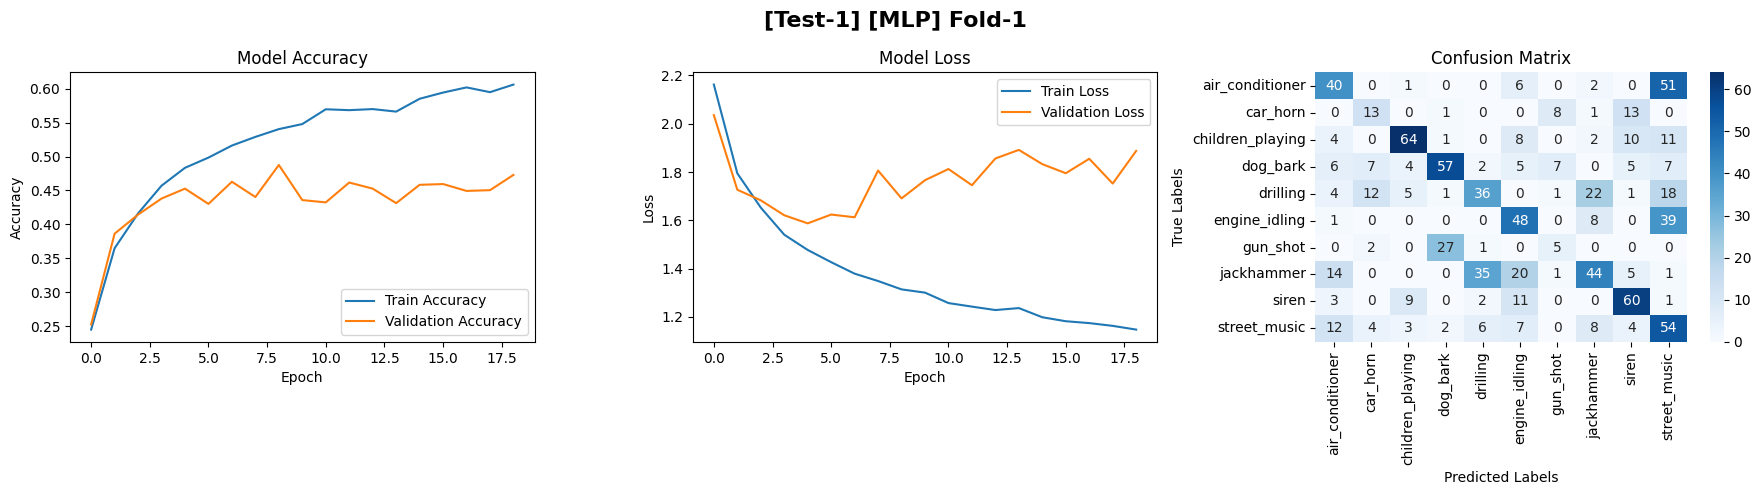

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


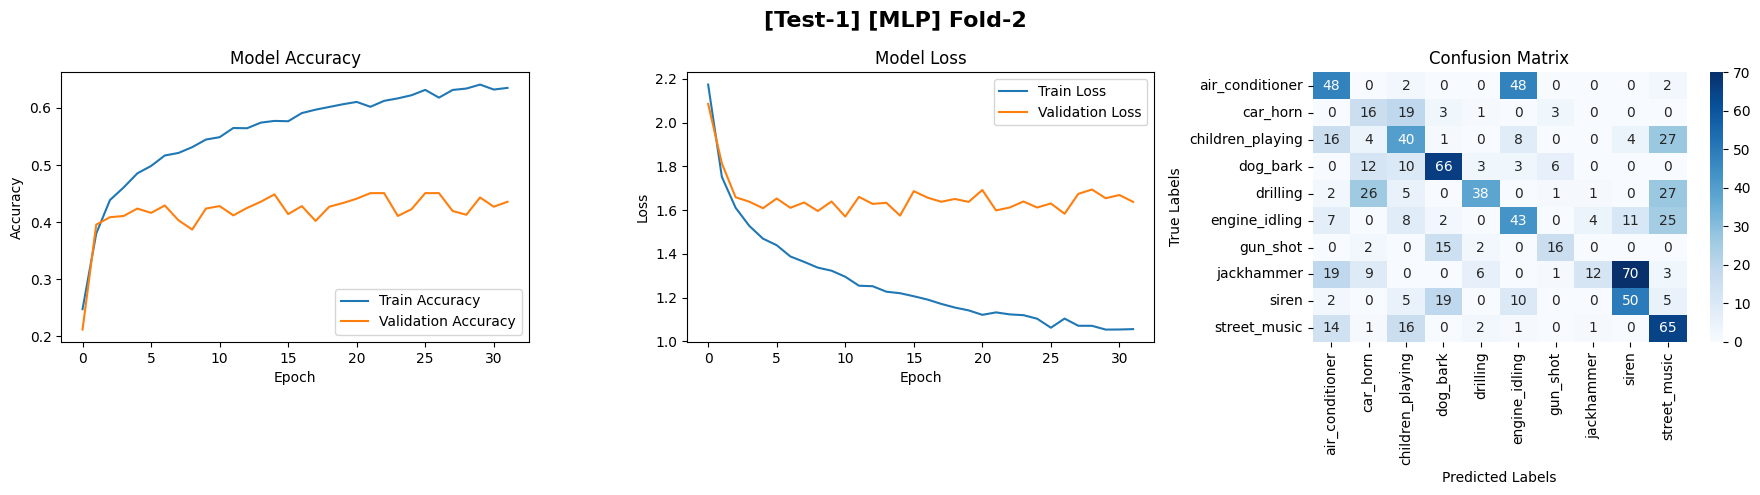

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


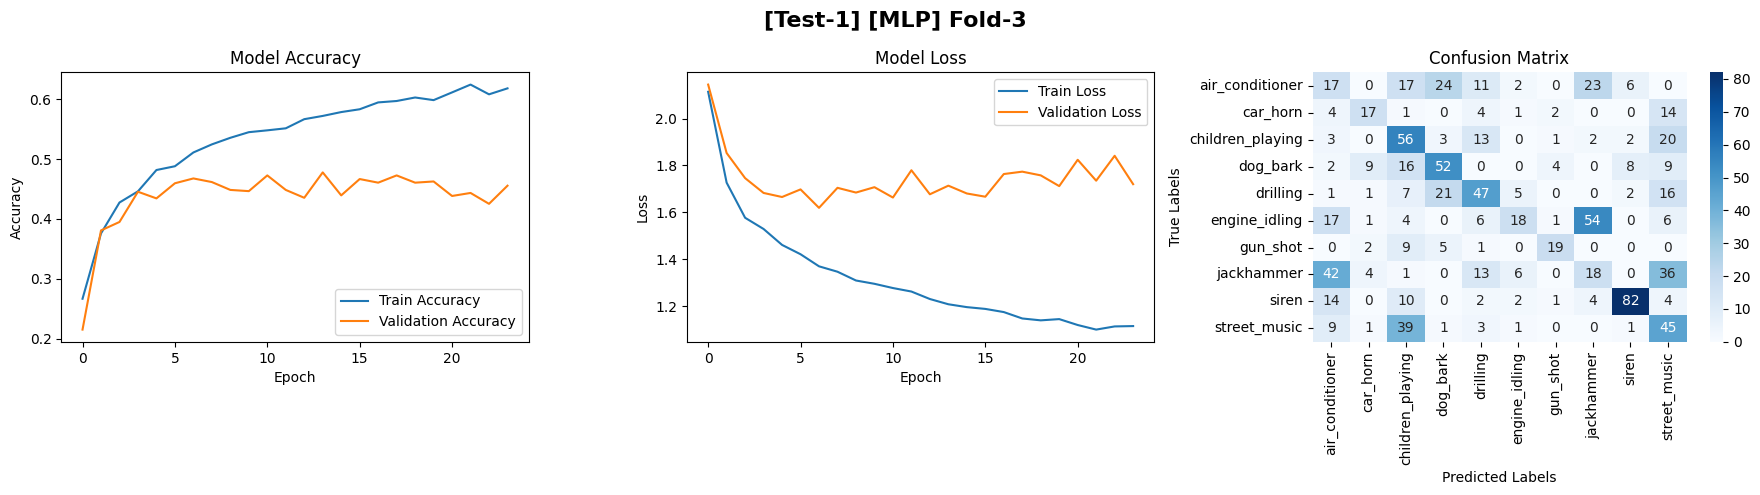

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


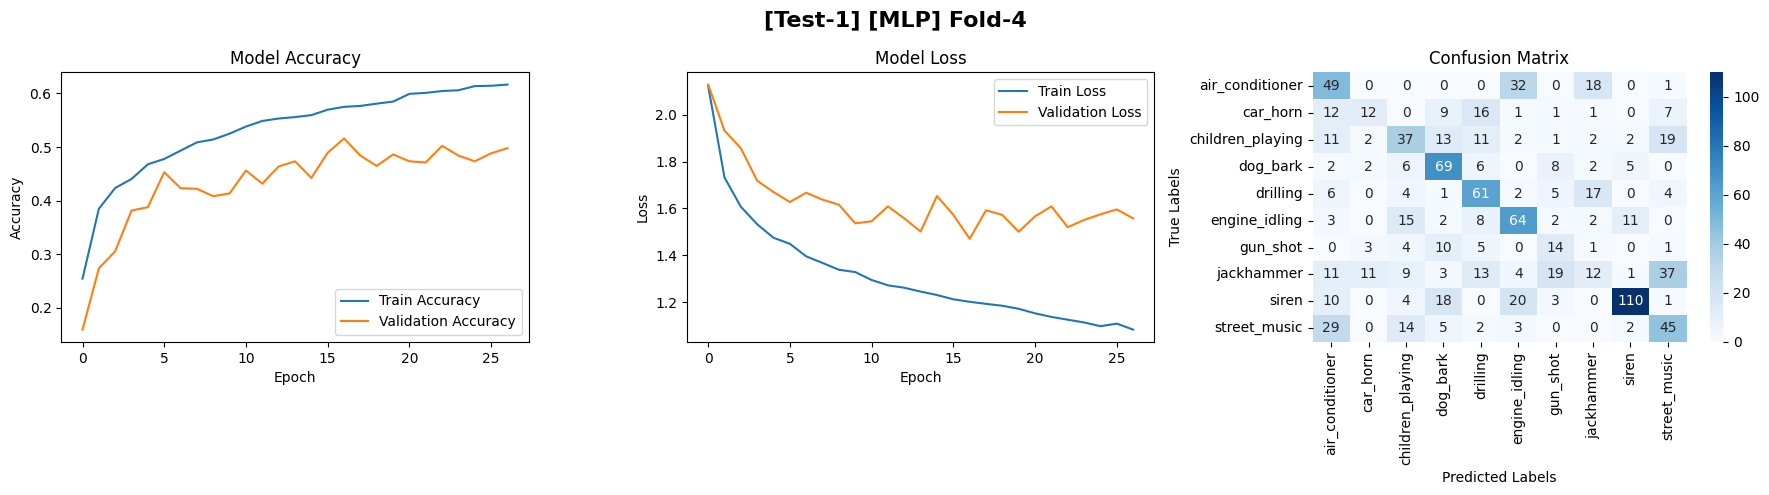

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


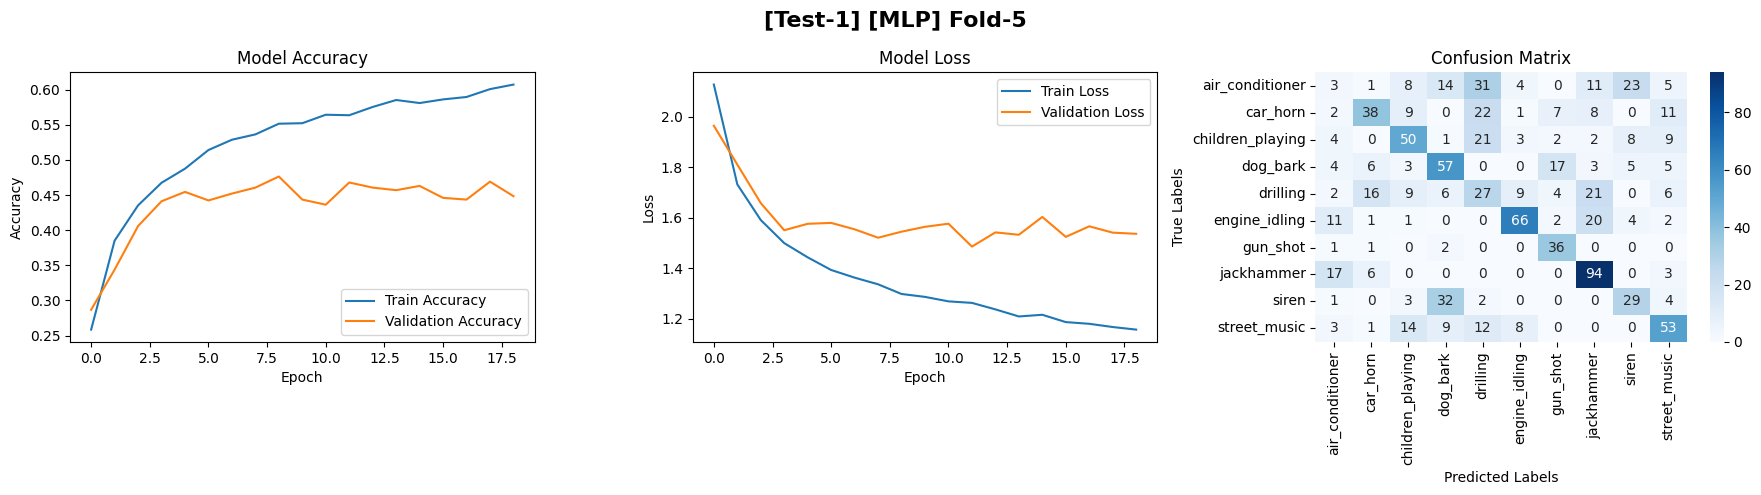

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


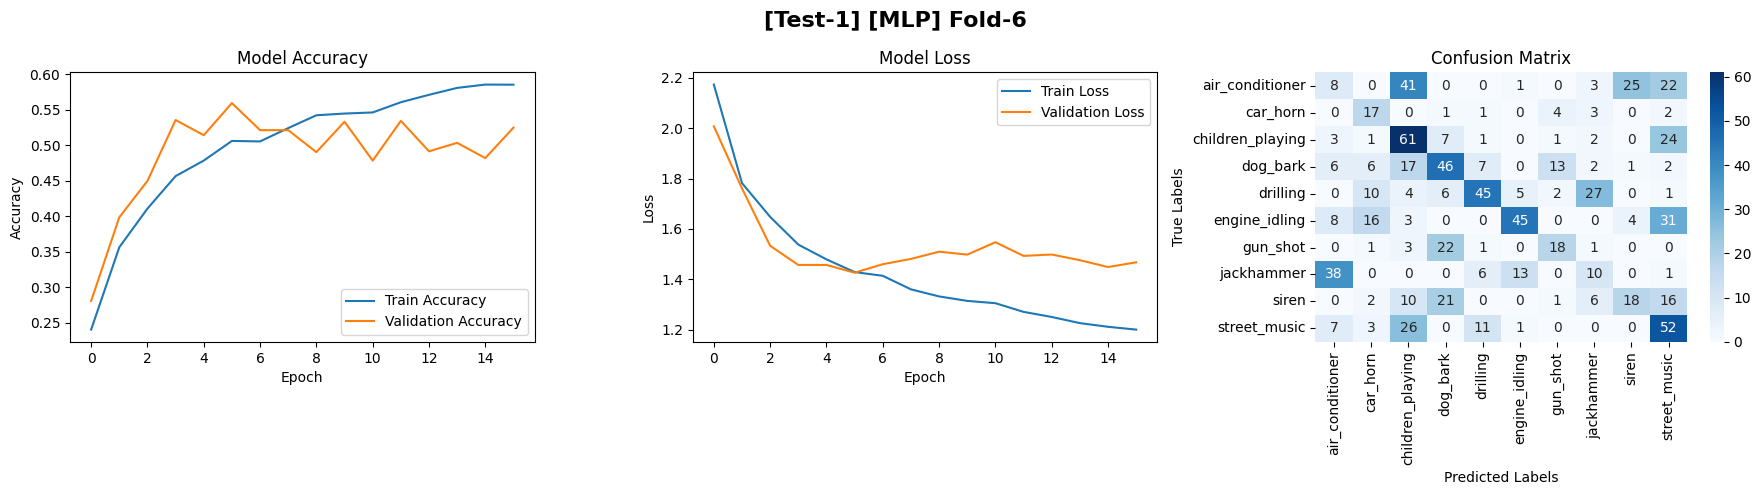

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


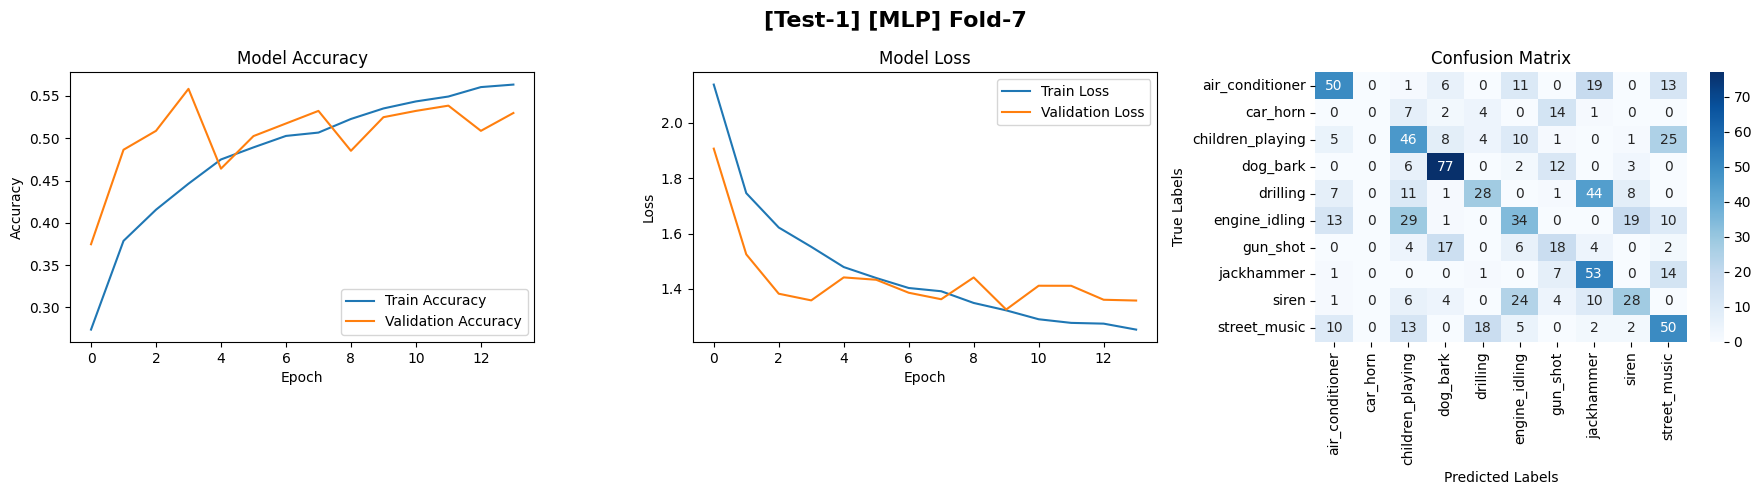

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


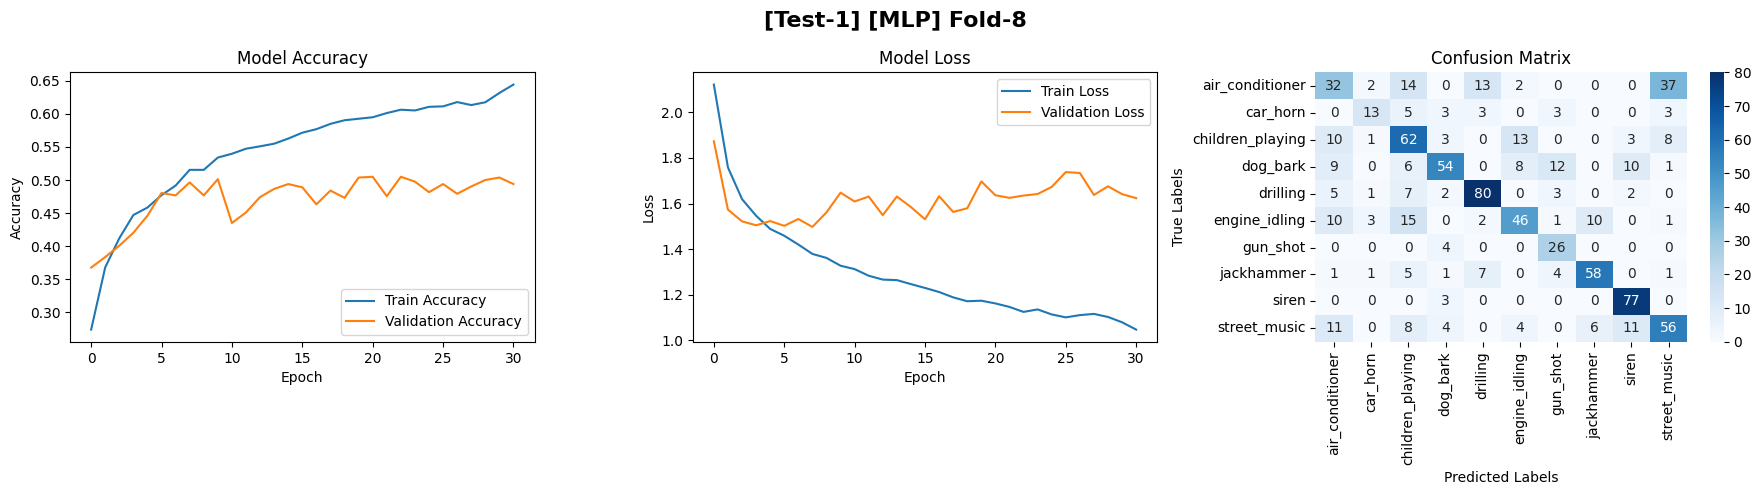

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


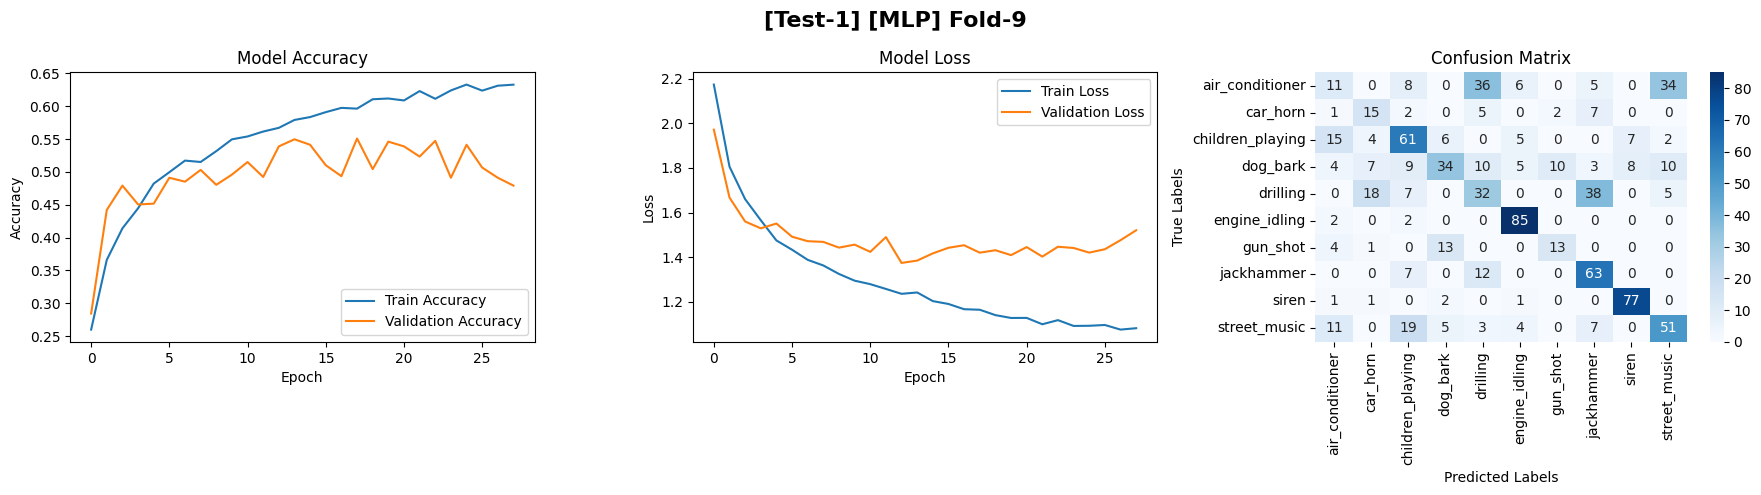

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


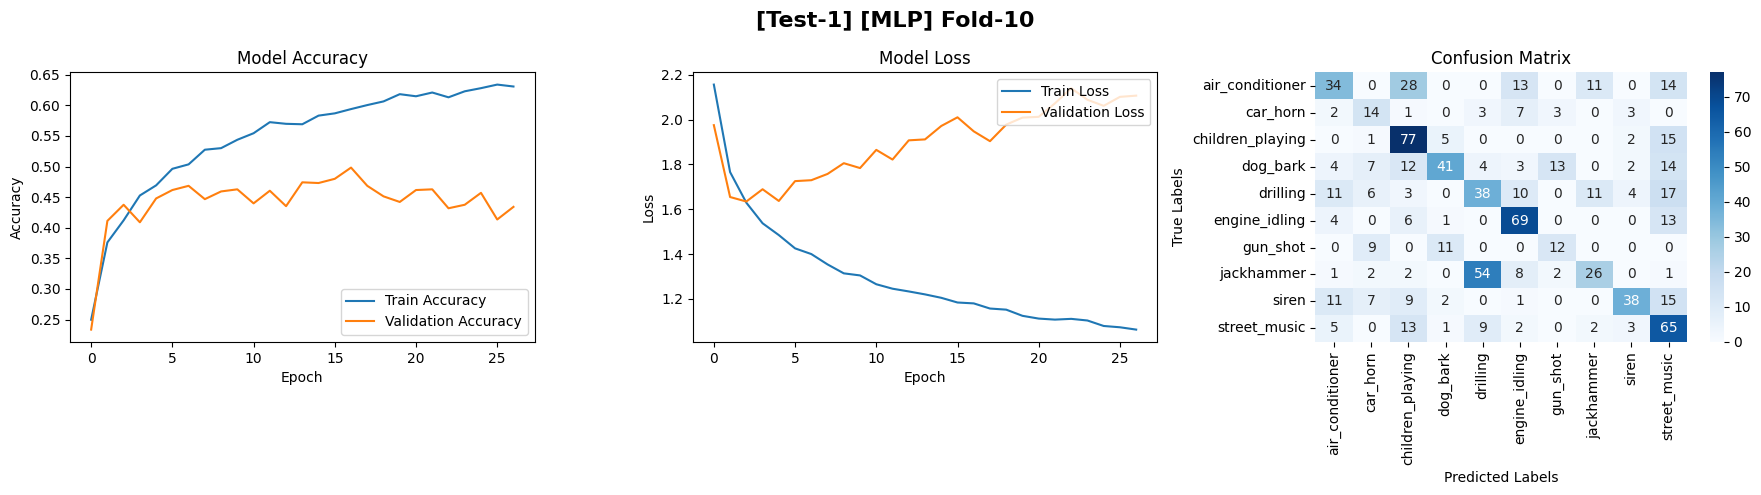

In [11]:
# Perform Cross Validation
_, histories, confusionMatrices = mlpDataManager.crossValidate(createModel=createMLP(input_shape=(13,), lr=0.001), numberFolds=10, epochs=50, callbacks=callbacks)

The training and validation accuracies and losses obtained from our network clearly indicate the **presence of overfitting**, which affects the model's classification performance on the test set.

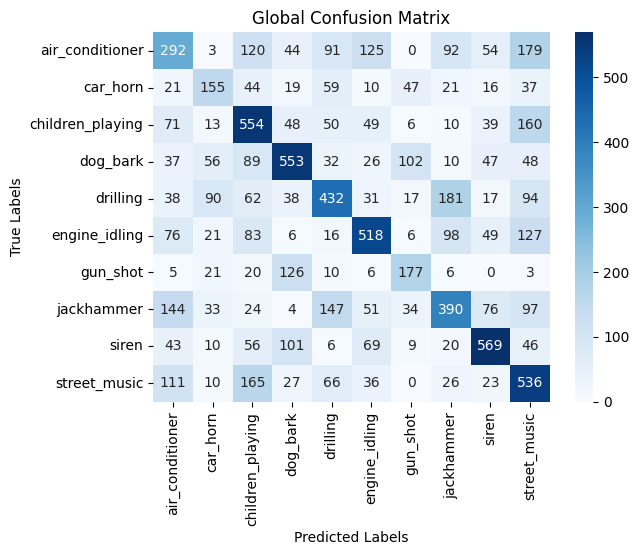

In [12]:
# Plot the Global Confusion Matrix
mlpDataManager.plotGlobalConfusionMatrix(confusionMatrices)

The model has shown **relatively good performance**, even though the **validation accuracy remains at around 50%**. Given the nature of this **multiclass classification task**, the model demonstrates the ability to **identify certain classes more effectively than others**. As we can observe, it **excels in recognizing siren sounds** while **struggling to generalize well for classes like air_conditioner**. However, as a initial approach, this model demonstrates **promising potential** for further refinement and improvement.

---
### Test 2
---

Up next we are going to evaluate how the **segmented windows of the raw extracted 1-Dimensional data** perform on the same architecture.

In [13]:
# Create a instance of the MLP and inspect its architecture
mlpModel = createMLP(input_shape=(255,), lr=0.001)(testNumber=2)
mlpModel.summary()

Model: "MLP-V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 80)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 80)                  │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,310 (98.87 KB)

 Trainable params: 25,030 (97.77 KB)

 Non-trainable params: 280 (1.09 KB)

In [14]:
# Load the Dataset with the 1-Dimensional Extracted Data
mlpDataManager = UrbanSound8kManager(featuresToUse='1D-Processed-Features', modelType="MLP", testNumber=2, pathsConfig=pathsConfig)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


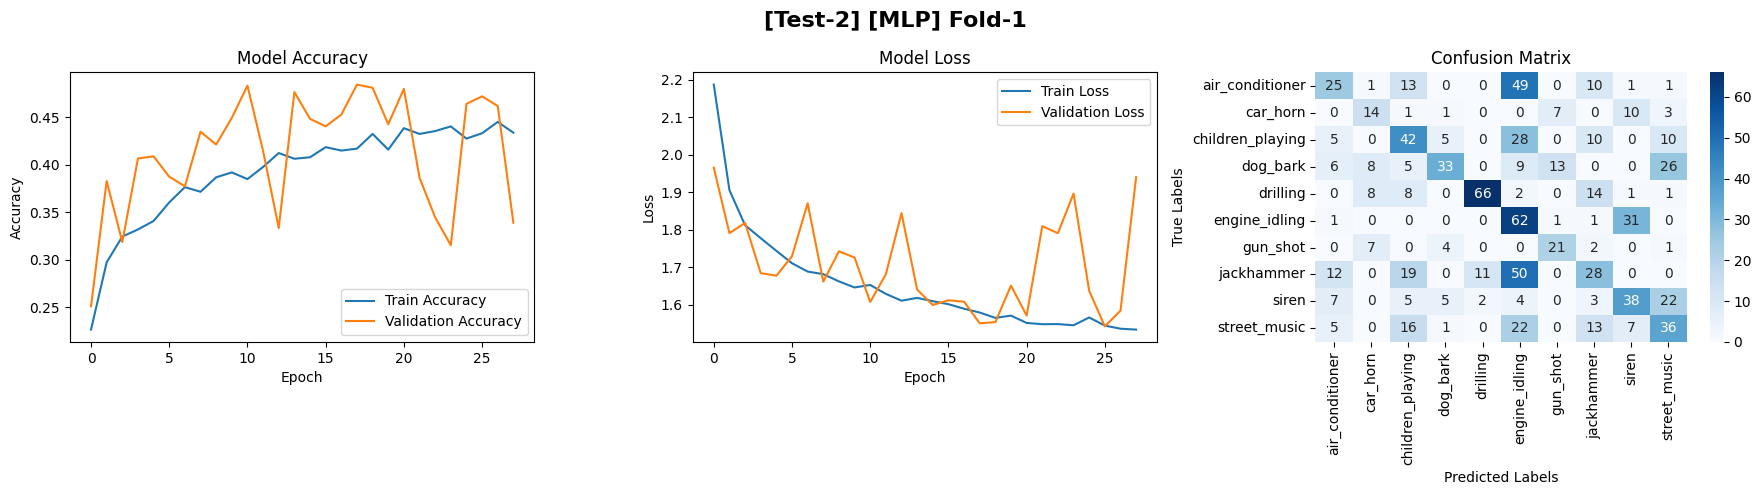

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


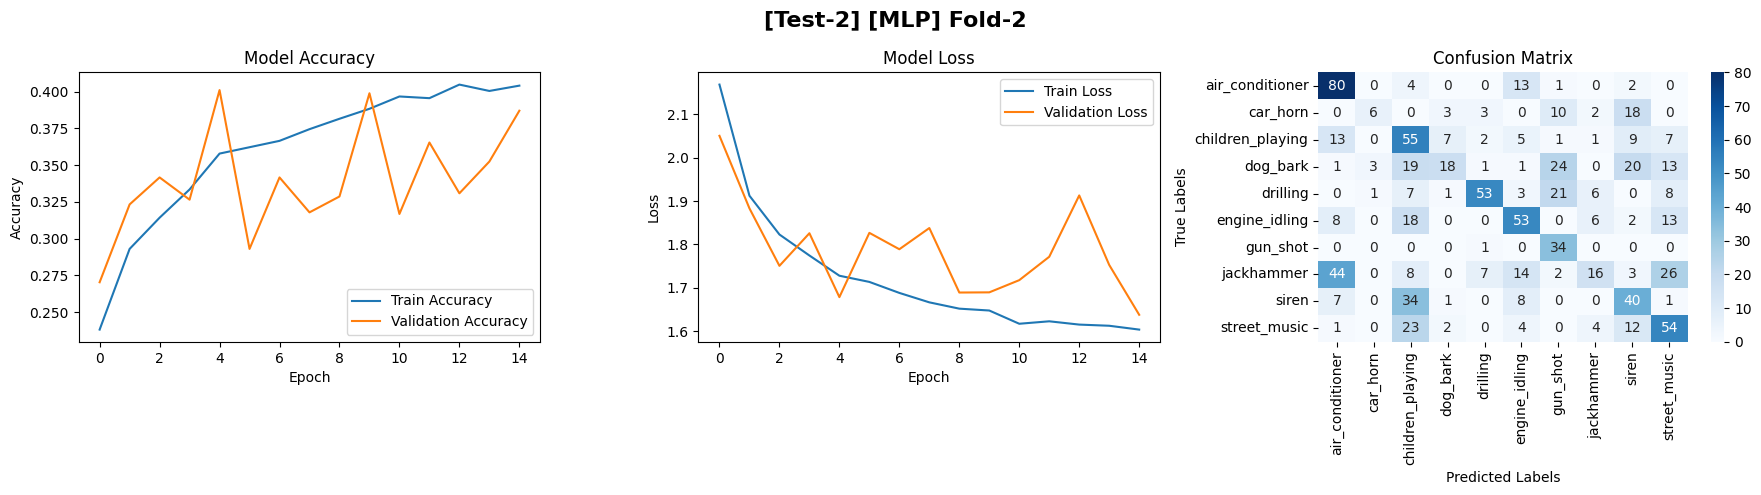

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


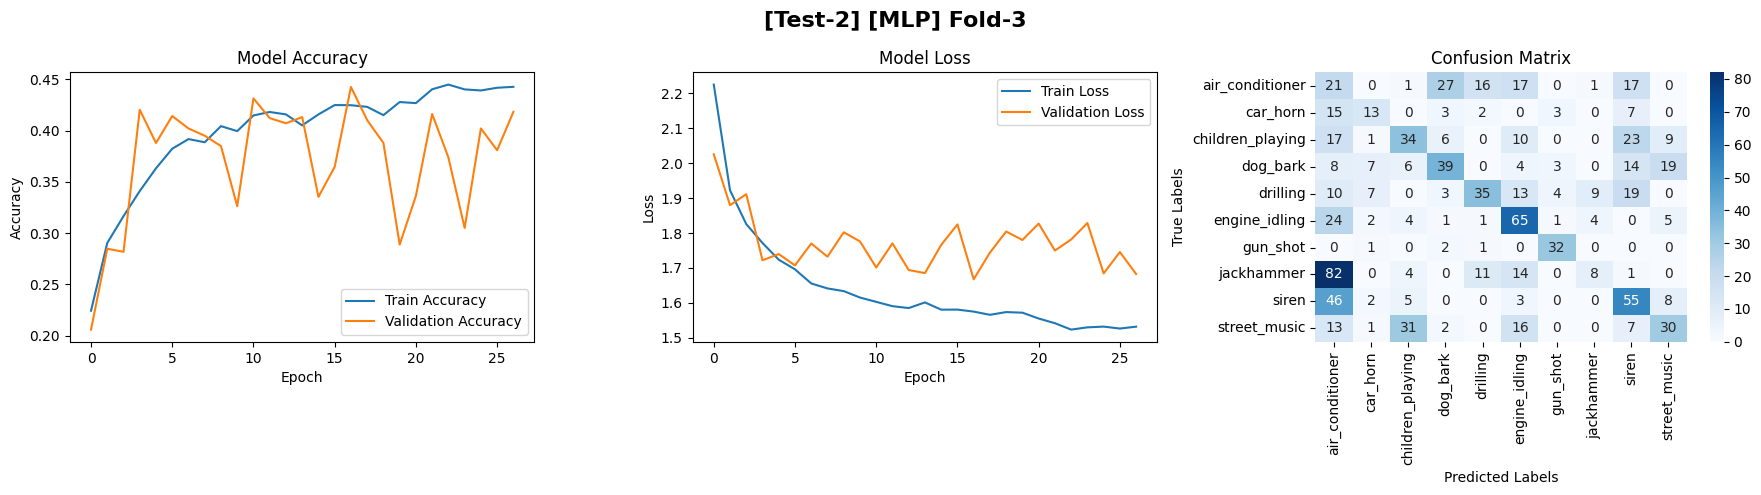

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


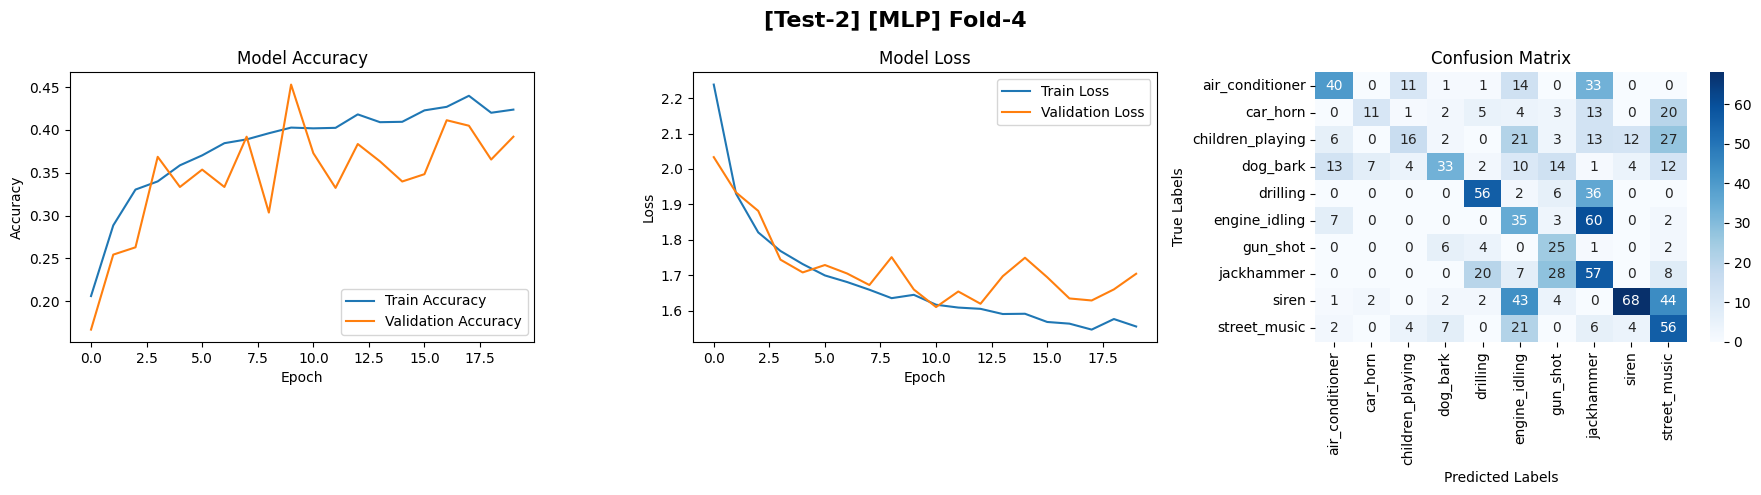

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


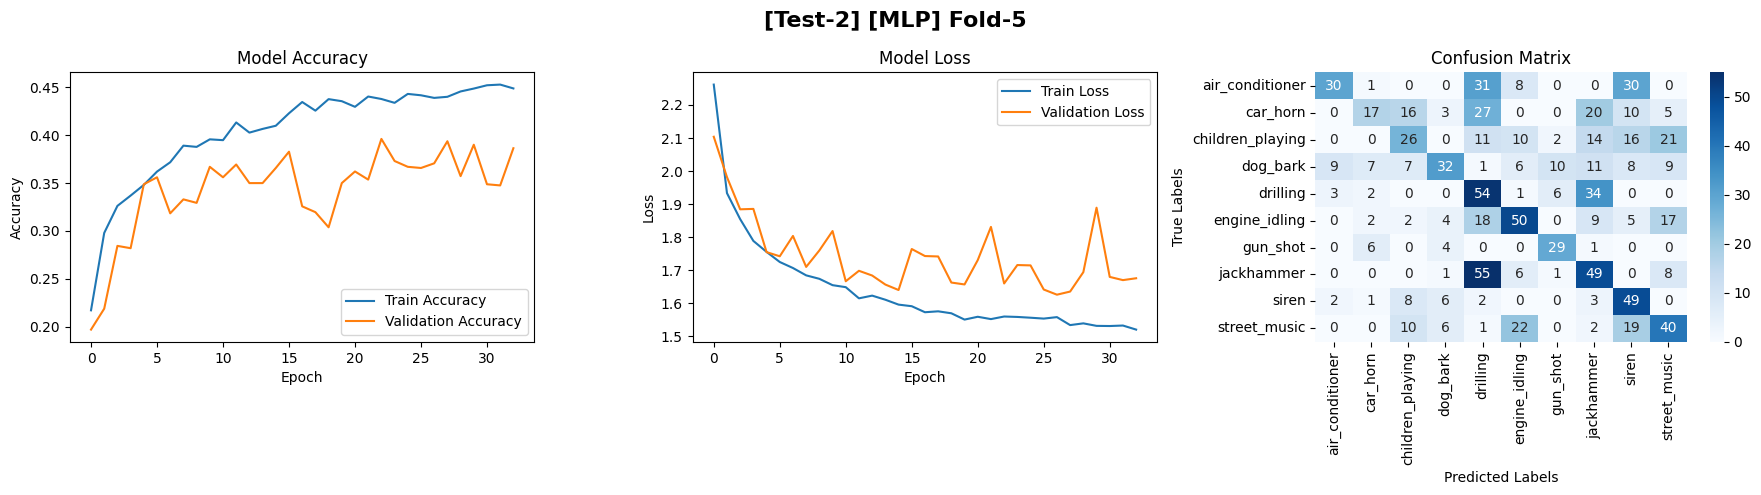

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


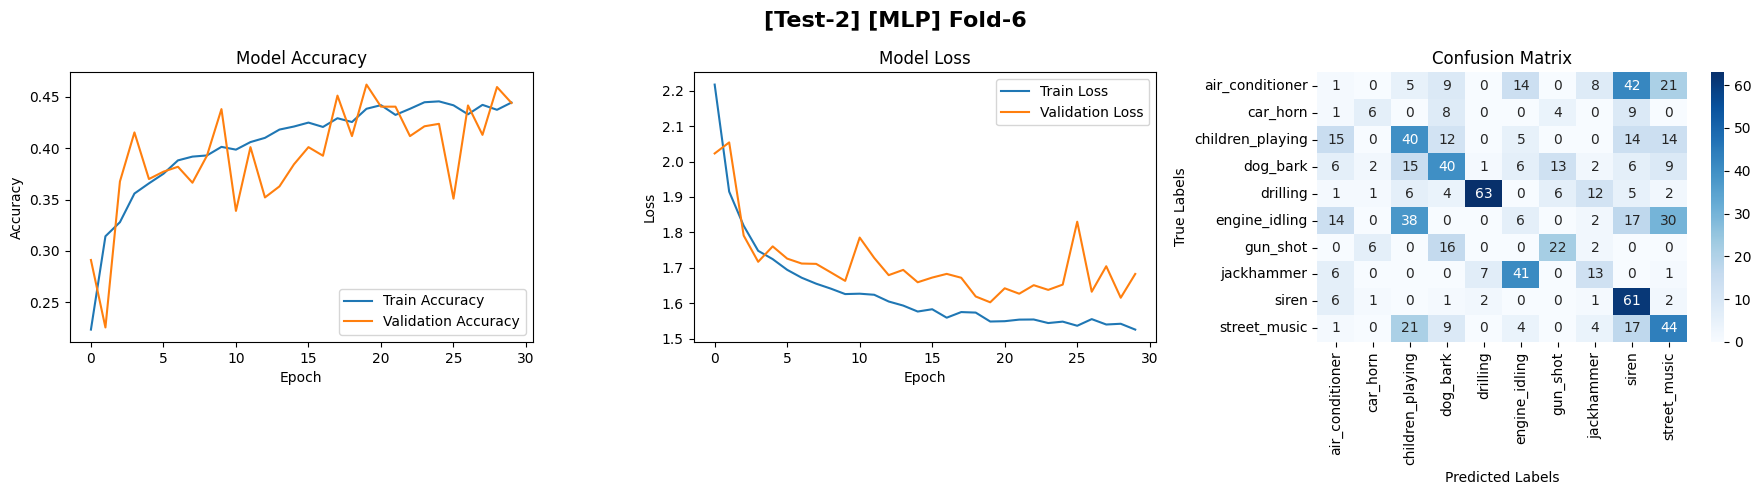

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


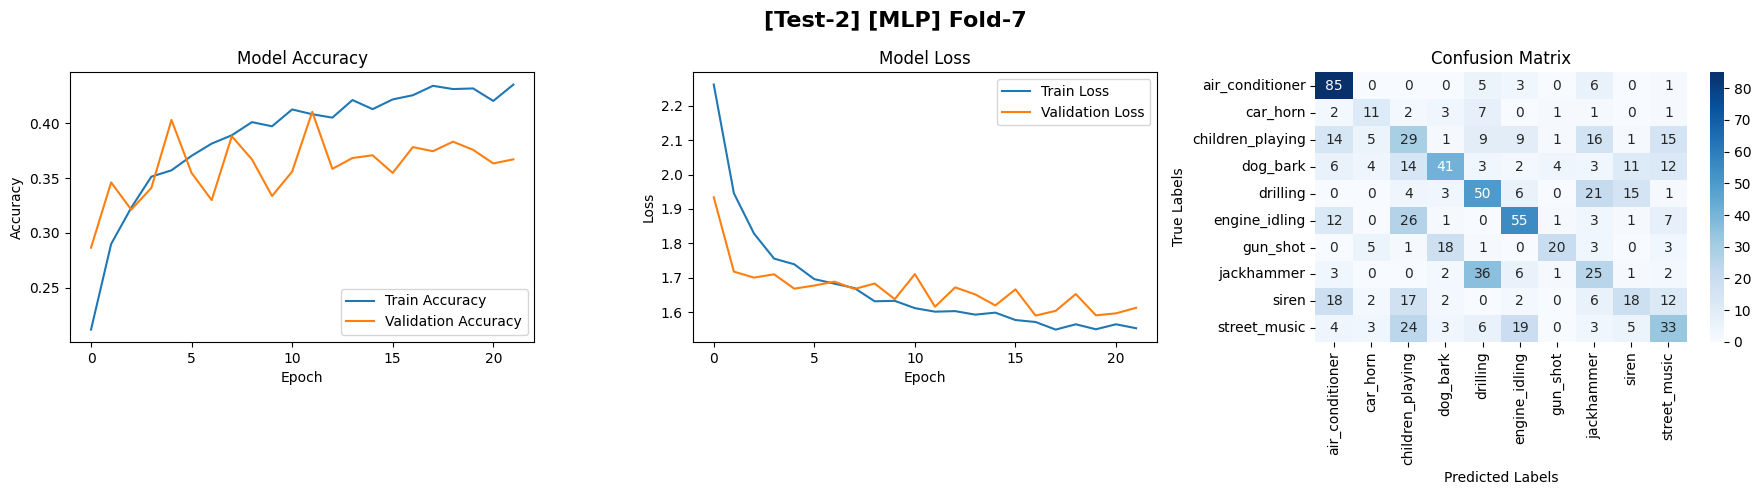

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


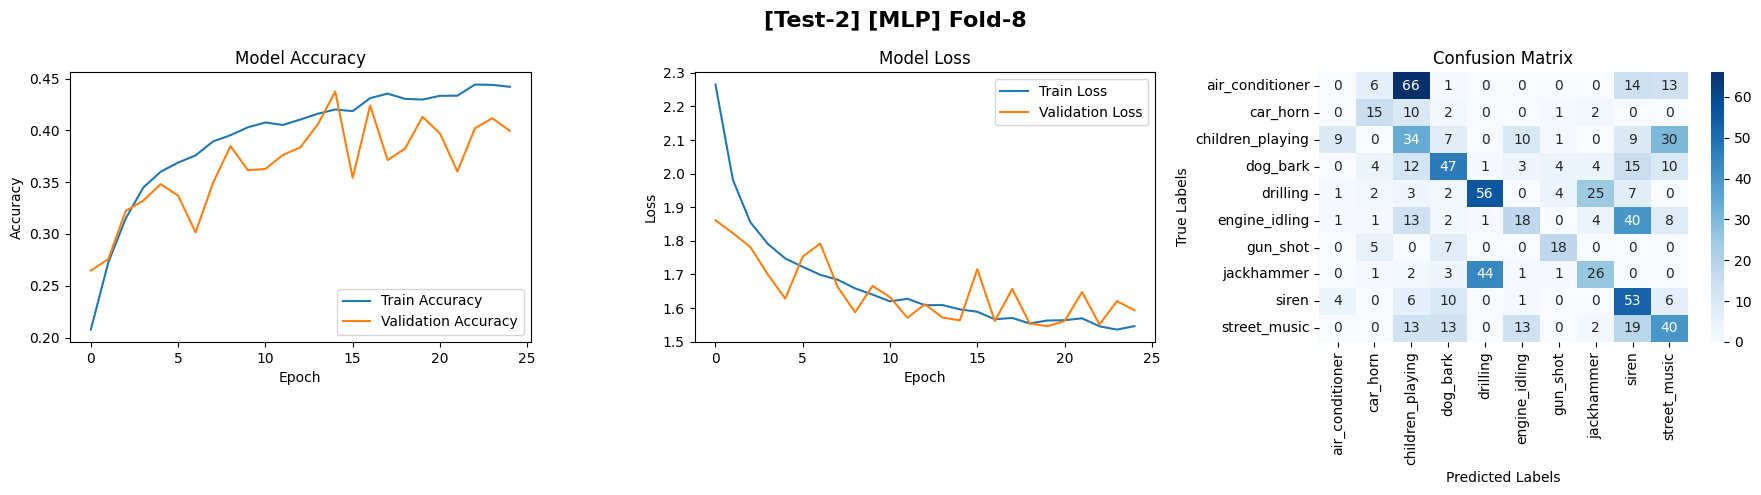

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


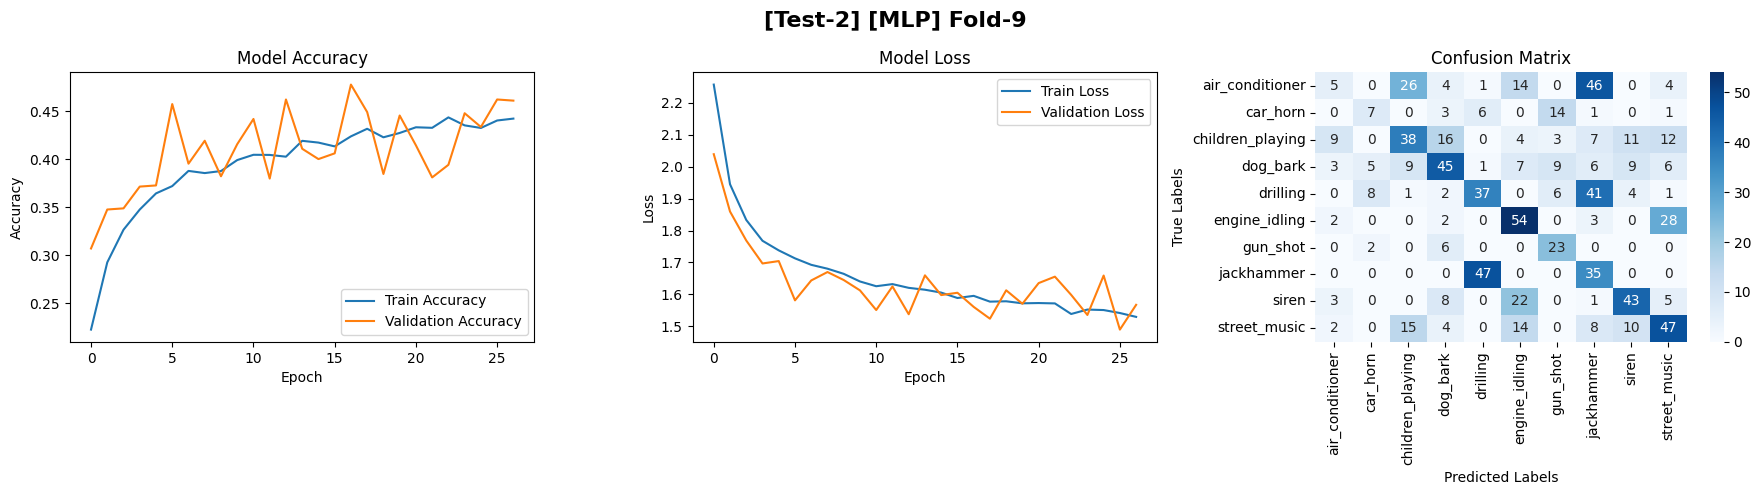

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


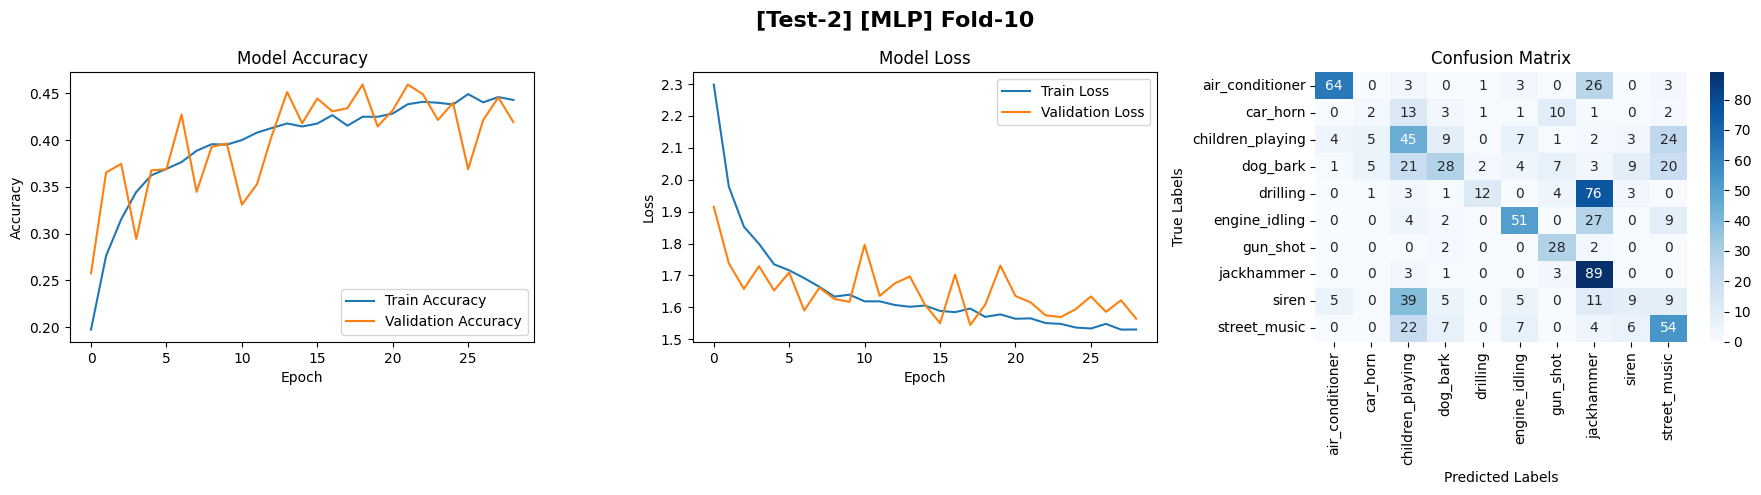

In [15]:
# Perform Cross Validation
_, histories, confusionMatrices = mlpDataManager.crossValidate(createModel=createMLP(input_shape=(255,), lr=0.001), numberFolds=10, epochs=50, callbacks=callbacks)

As we can observe from the model's accuracy and loss on the validation set, its performance **is noticeably less stable** compared to its behavior on the training set.

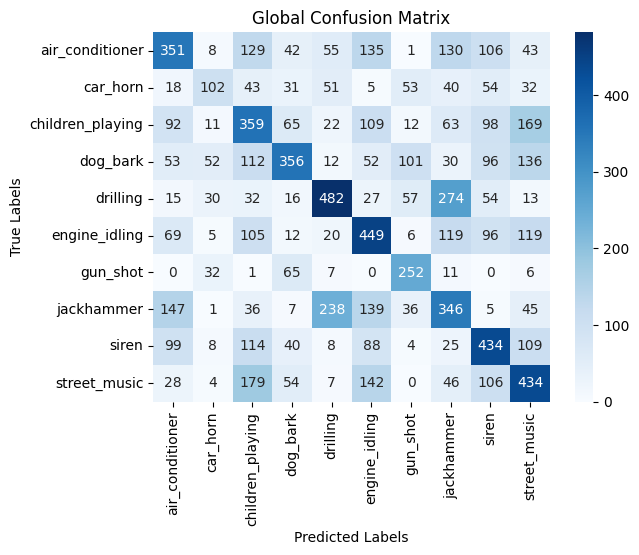

In [16]:
# Plot the Global Confusion Matrix
mlpDataManager.plotGlobalConfusionMatrix(confusionMatrices)

Compared to the initial test, the model shows **underperformance across almost all target class labels**, as evidenced by the higher number of misclassified instances. This highlights that the **processed 1-dimensional data** derived from MFCCs has the potential to significantly enhance the model's overall performance. As a result, for further **tuning of the MLP architecture**, we will focus exclusively on **utilizing the 1-dimensional data derived from the MFCCs**.

---
### Test 3
---

In this next test, we have **increased the dropout rate and the number of units in each Dense Layer** to try to address and **reduce the overfitting** observed in our initial model.

In [17]:
# Create a instance of the MLP and inspect its architecture
mlpModel = createMLP(input_shape=(13,), lr=0.001)(testNumber=3)
mlpModel.summary()

Model: "MLP-V3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                     │ (None, 512)                 │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_69               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,138 (719.29 KB)

 Trainable params: 182,218 (711.79 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
# Load the Dataset with the 1-Dimensional Extracted Data
mlpDataManager = UrbanSound8kManager(featuresToUse='1D-Processed-MFCCs', modelType="MLP", testNumber=3, pathsConfig=pathsConfig)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


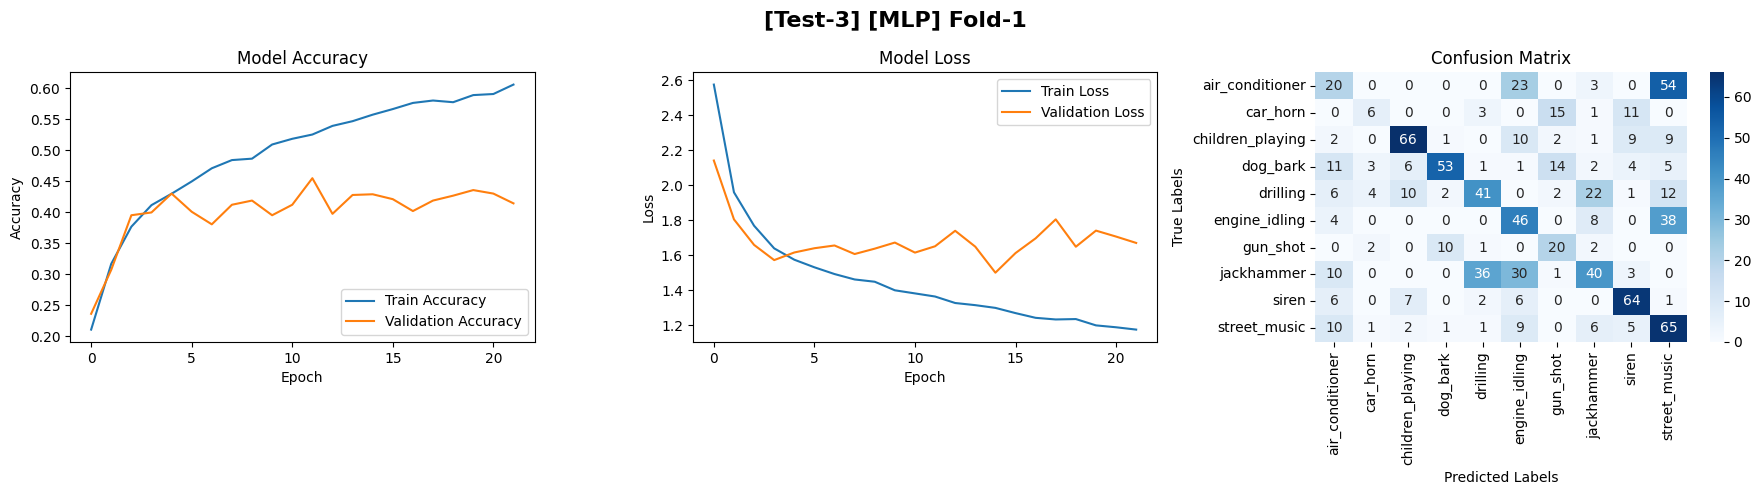

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


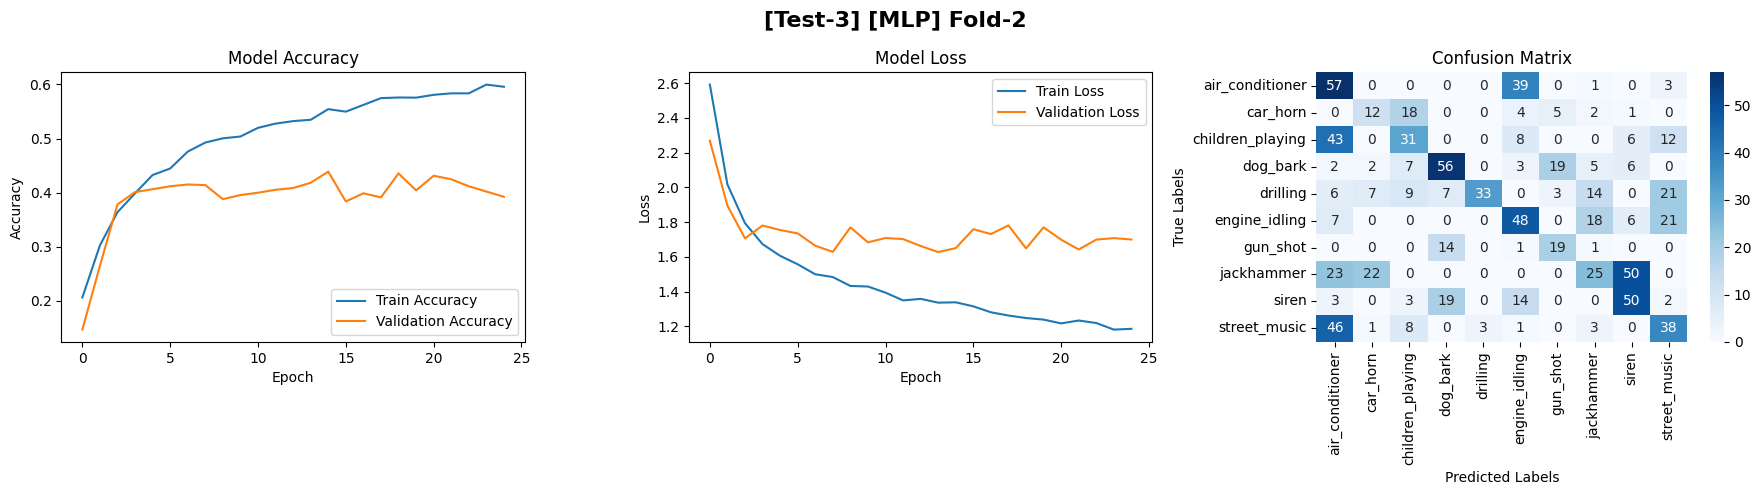

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


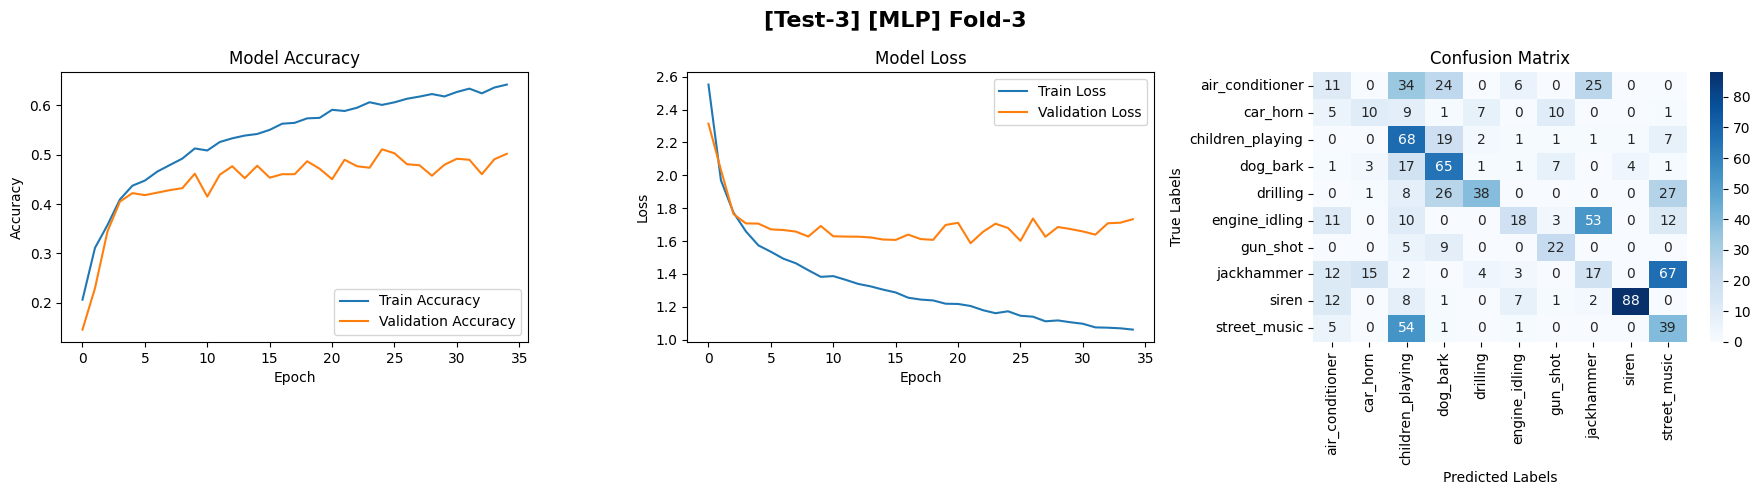

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


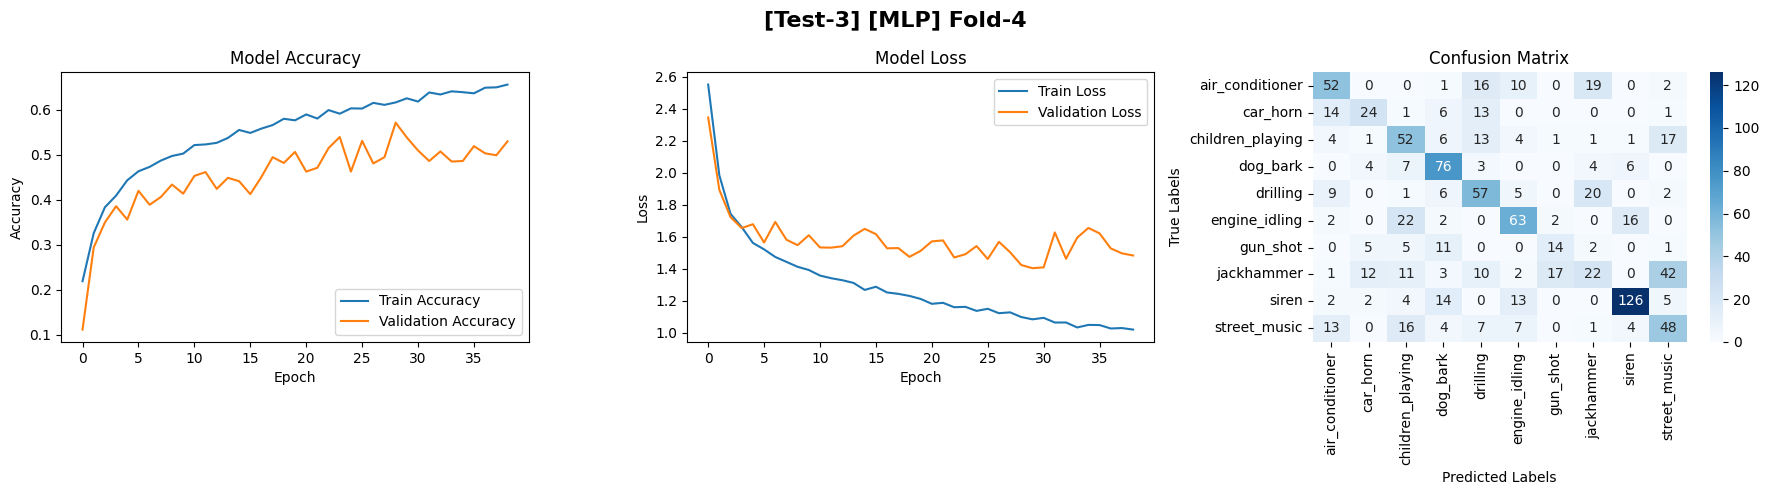

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


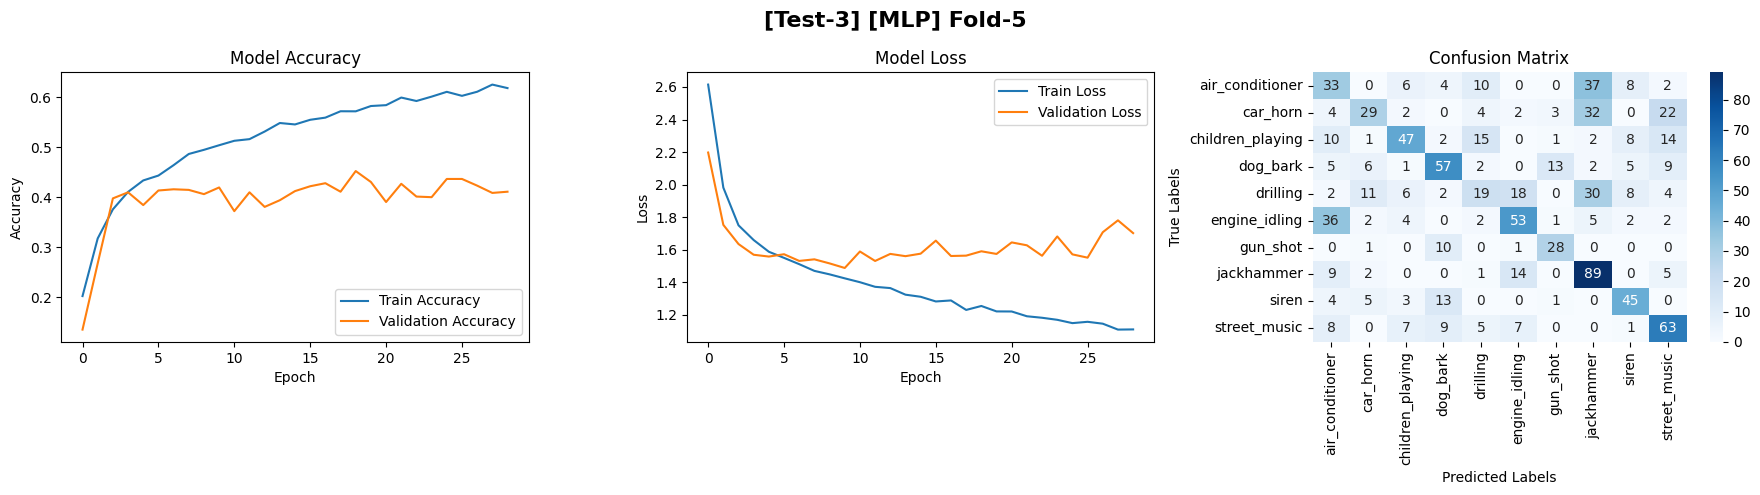

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


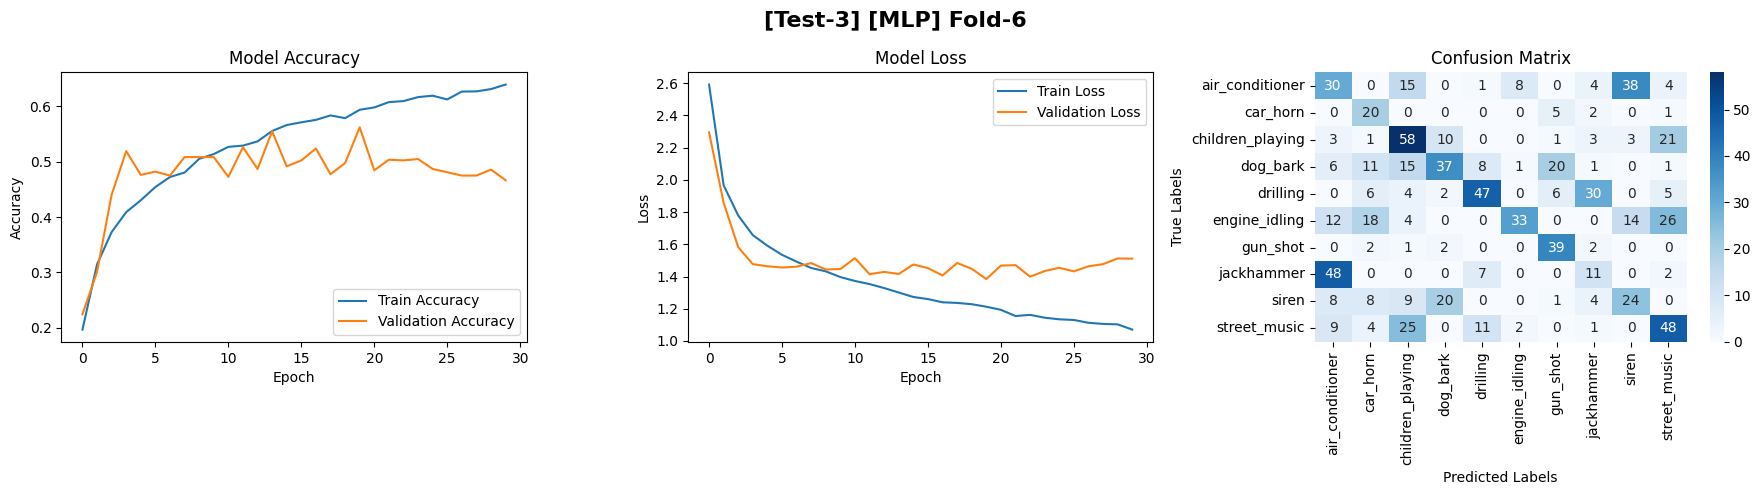

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


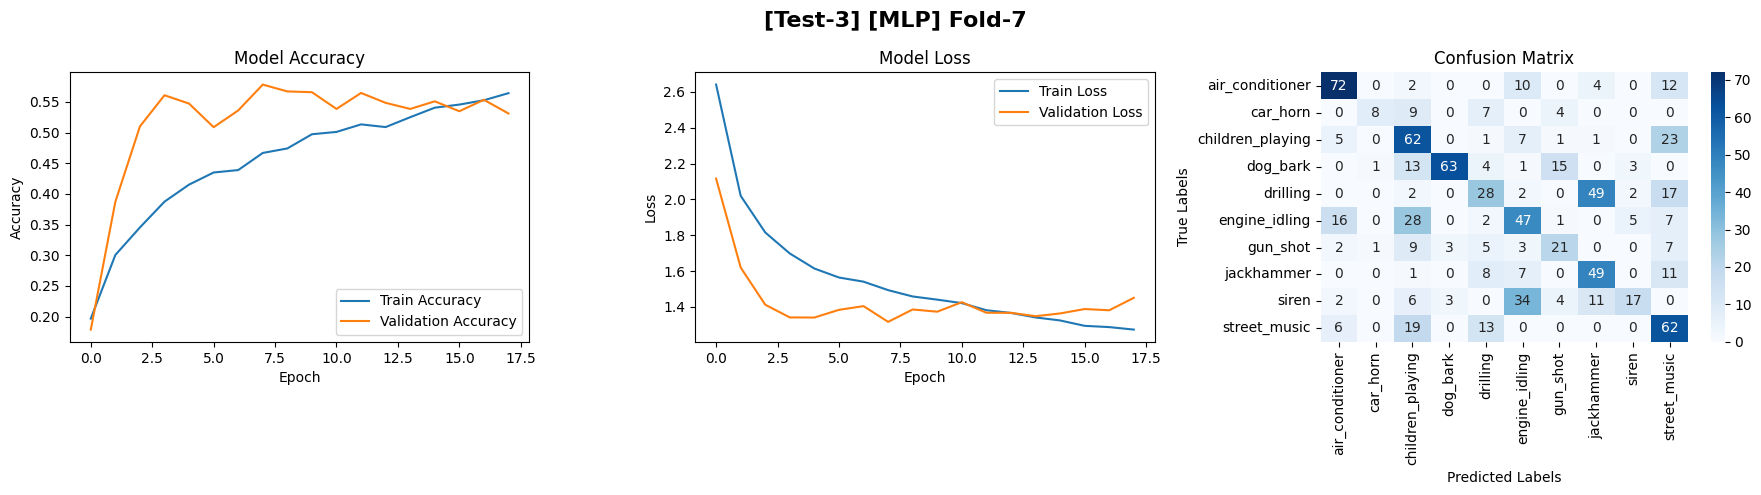

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


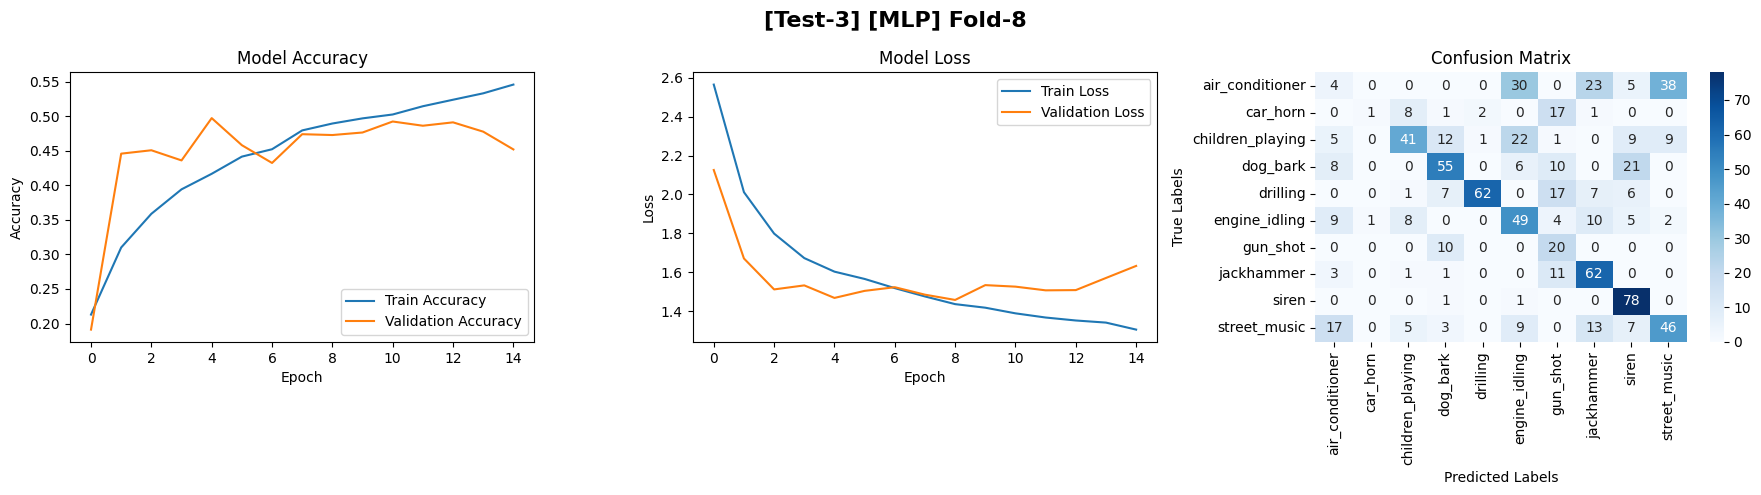

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


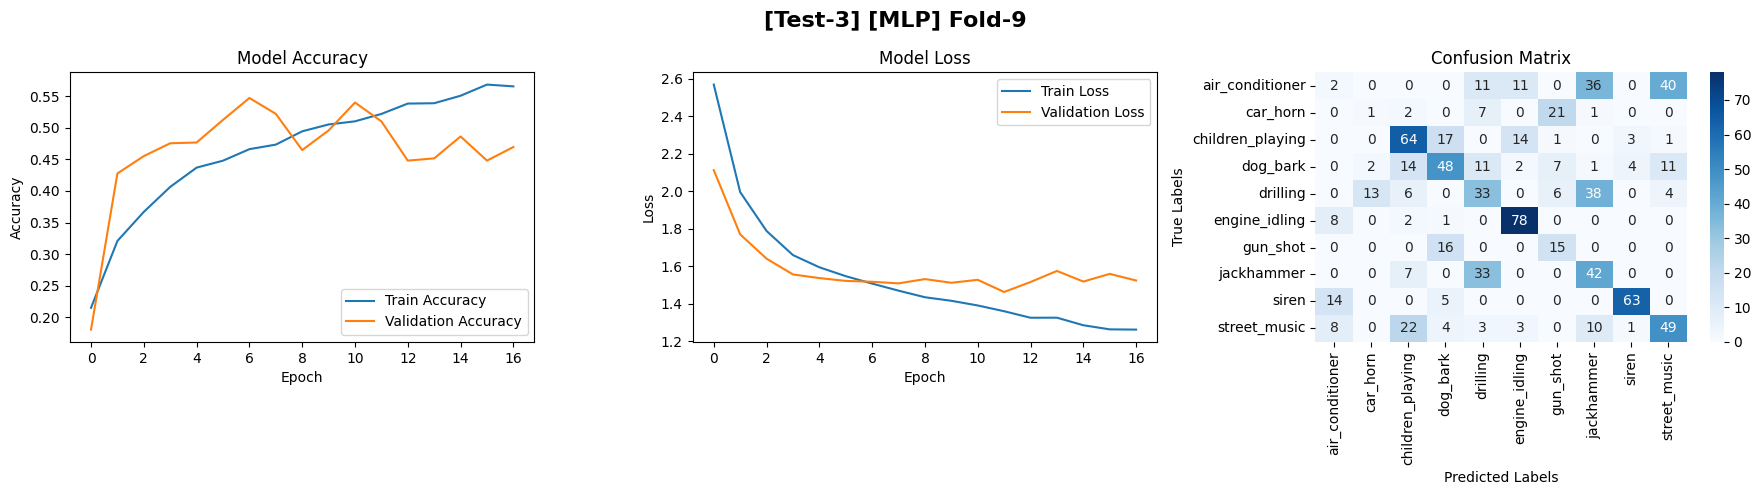

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


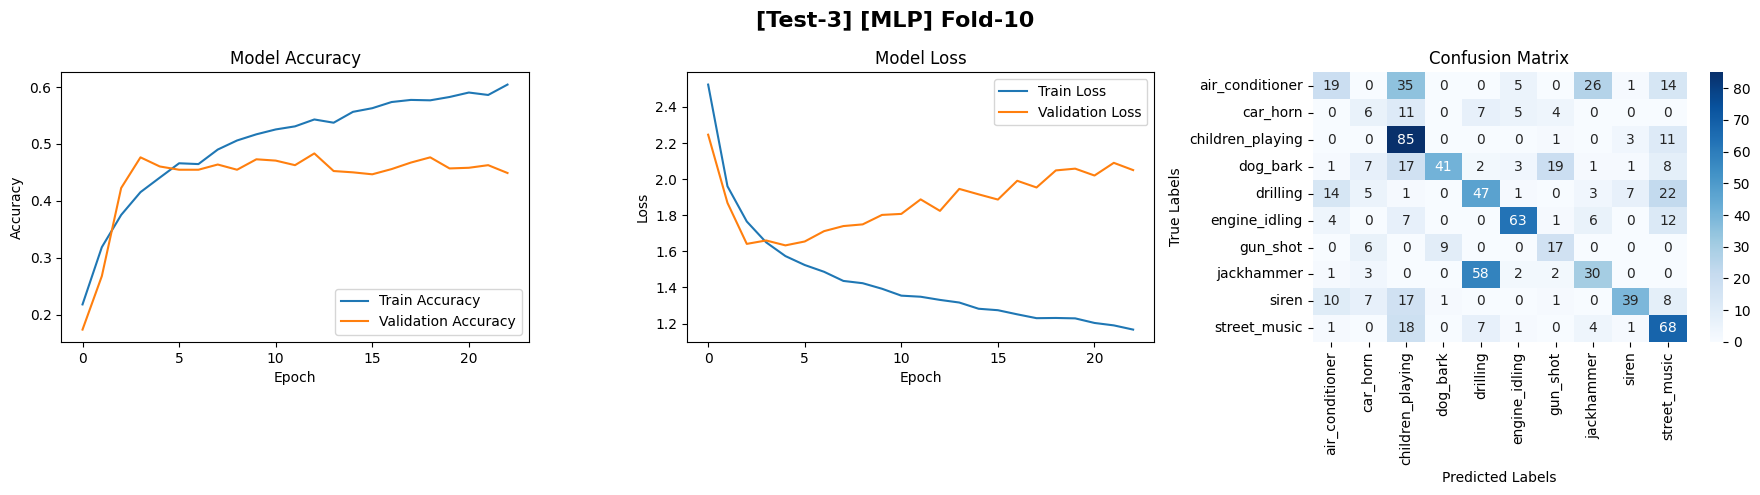

In [19]:
# Perform Cross Validation
mlpFoldsBalancedAccuracies, histories, confusionMatrices = mlpDataManager.crossValidate(createModel=createMLP(input_shape=(13,), lr=0.001), numberFolds=10, epochs=50, callbacks=callbacks)

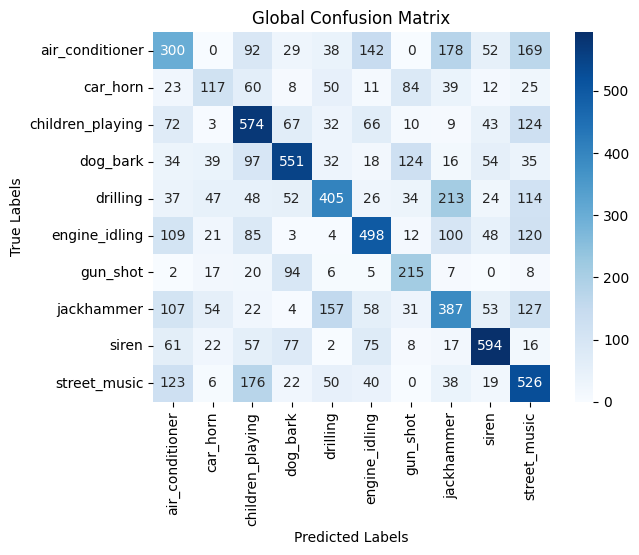

In [20]:
# Plot the Global Confusion Matrix
mlpDataManager.plotGlobalConfusionMatrix(confusionMatrices)

Although **overfitting has slightly decreased**, the model's **performance has not significantly improved** and remains largely unchanged.

---
### Test 4
---

In this next test, we have **increased the dropout rate and the number of units in each Dense Layer** to try to address and **reduce the overfitting** observed in our second model.

In [21]:
# Create a instance of the MLP and inspect its architecture
mlpModel = createMLP(input_shape=(255,), lr=0.001)(testNumber=4)
mlpModel.summary()

Model: "MLP-V4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_143 (Dense)                    │ (None, 512)                 │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_110              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_111              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_112              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_112 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_113              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,042 (1.18 MB)

 Trainable params: 306,122 (1.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [22]:
# Load the Dataset with the 1-Dimensional Extracted Data
mlpDataManager = UrbanSound8kManager(featuresToUse='1D-Processed-Features', modelType="MLP", testNumber=4, pathsConfig=pathsConfig)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


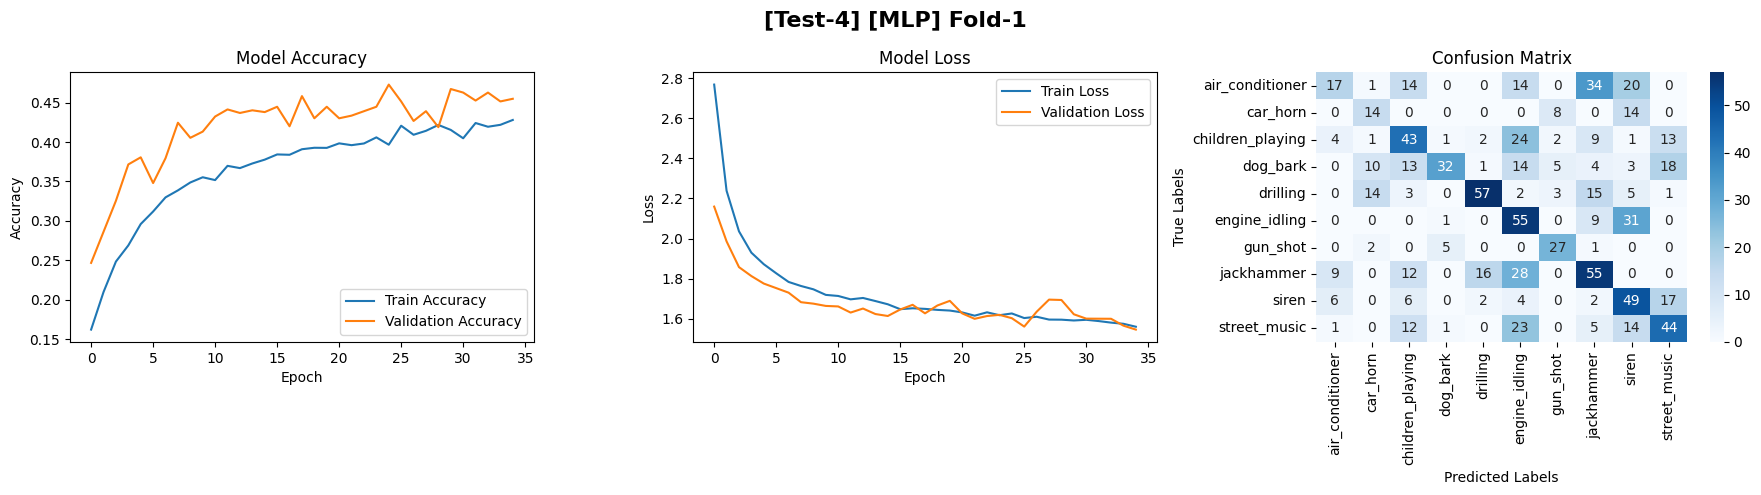

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


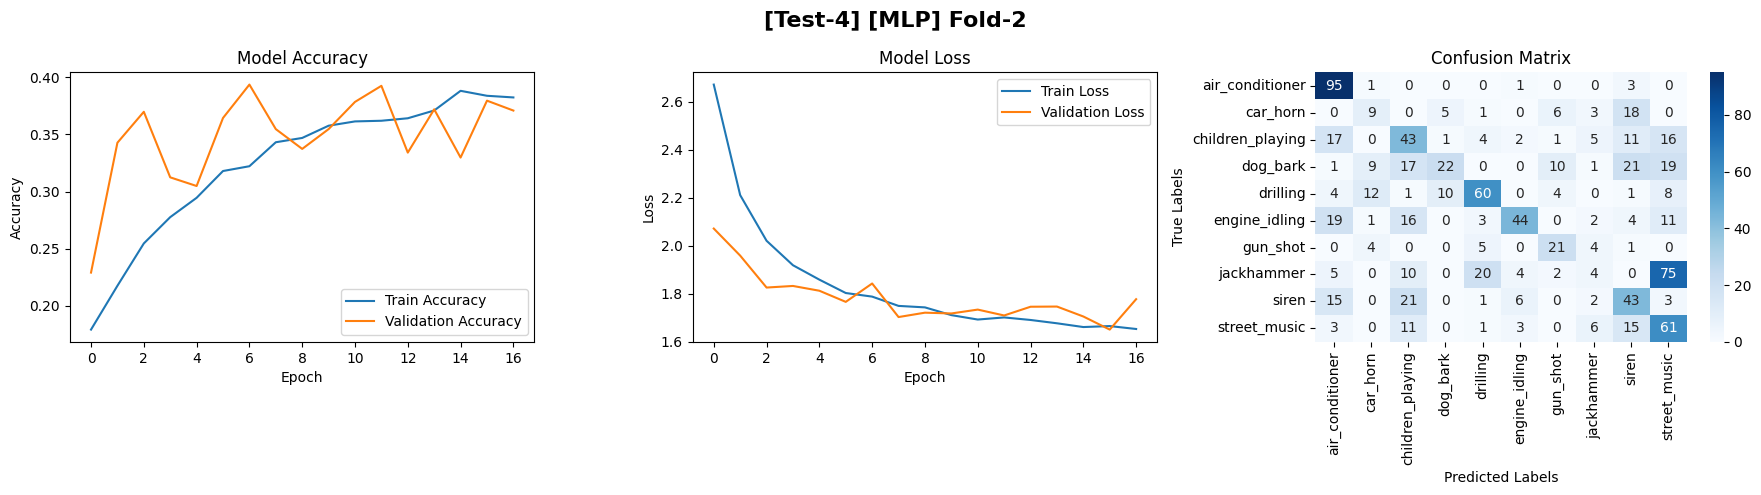

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


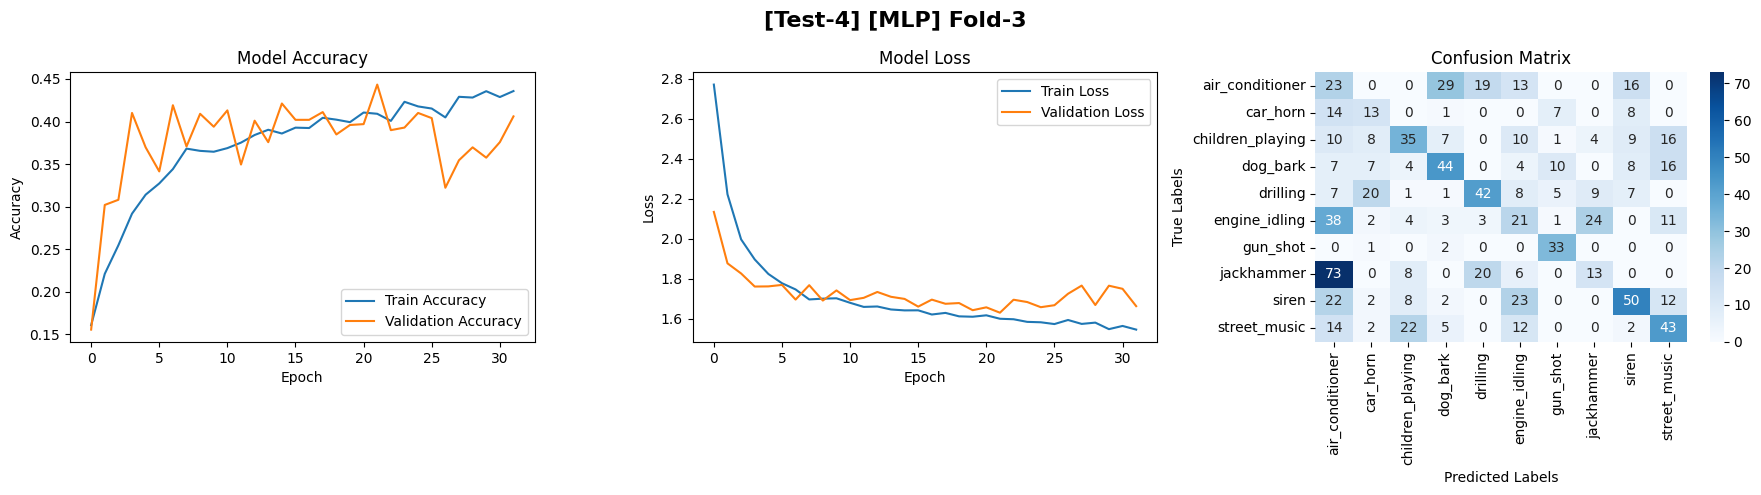

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


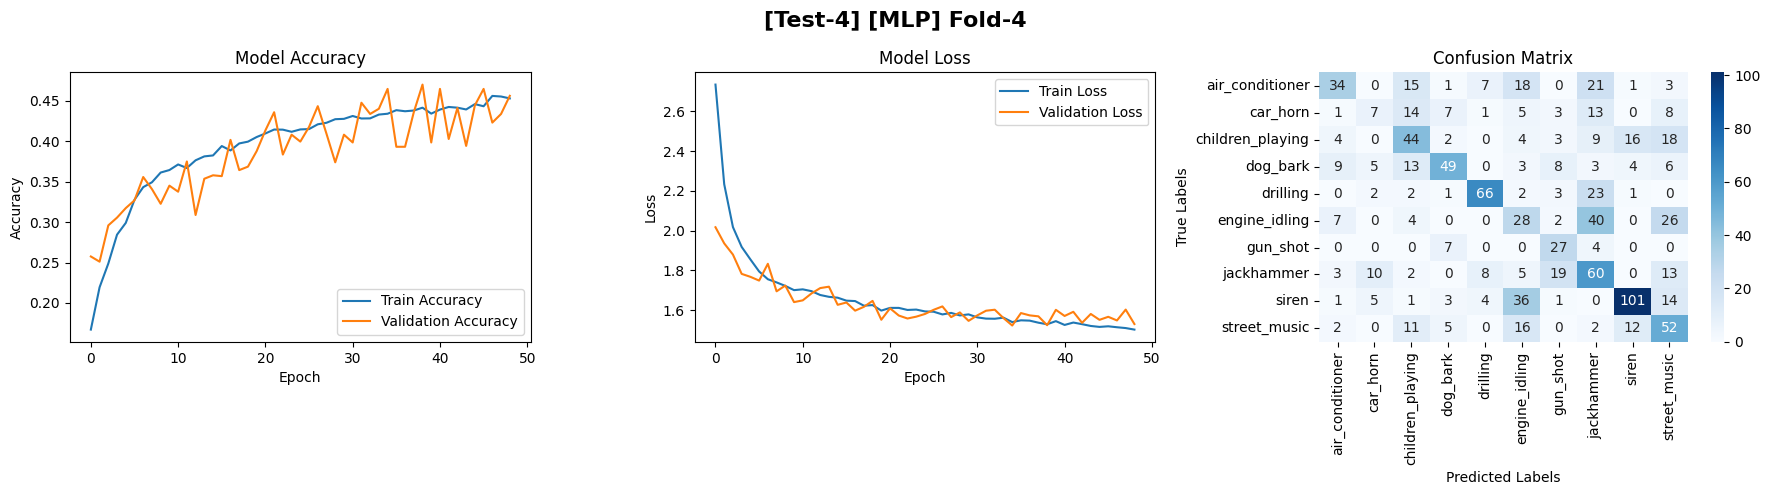

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


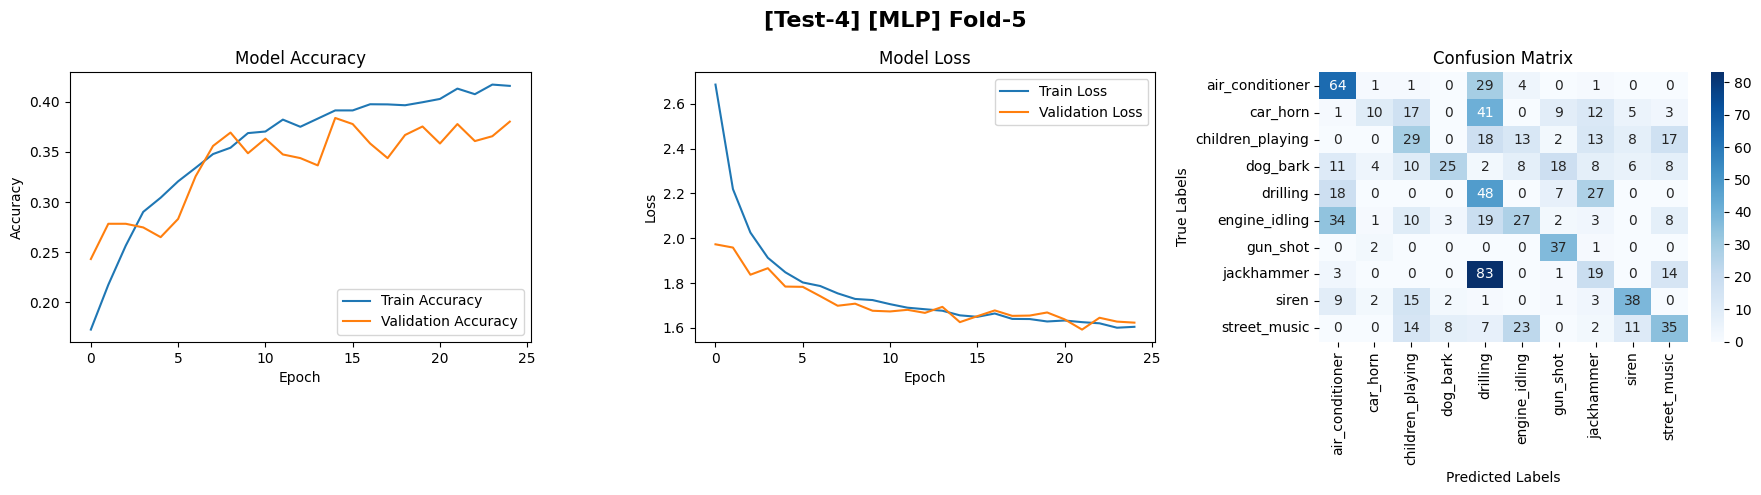

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


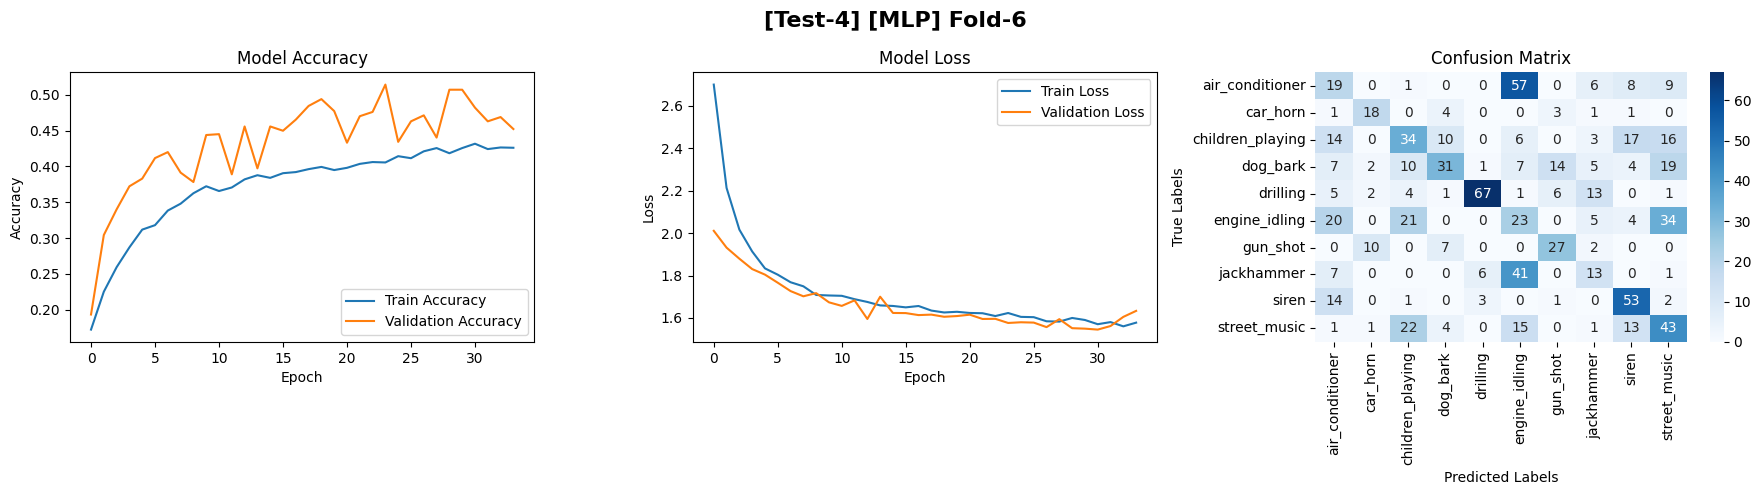

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


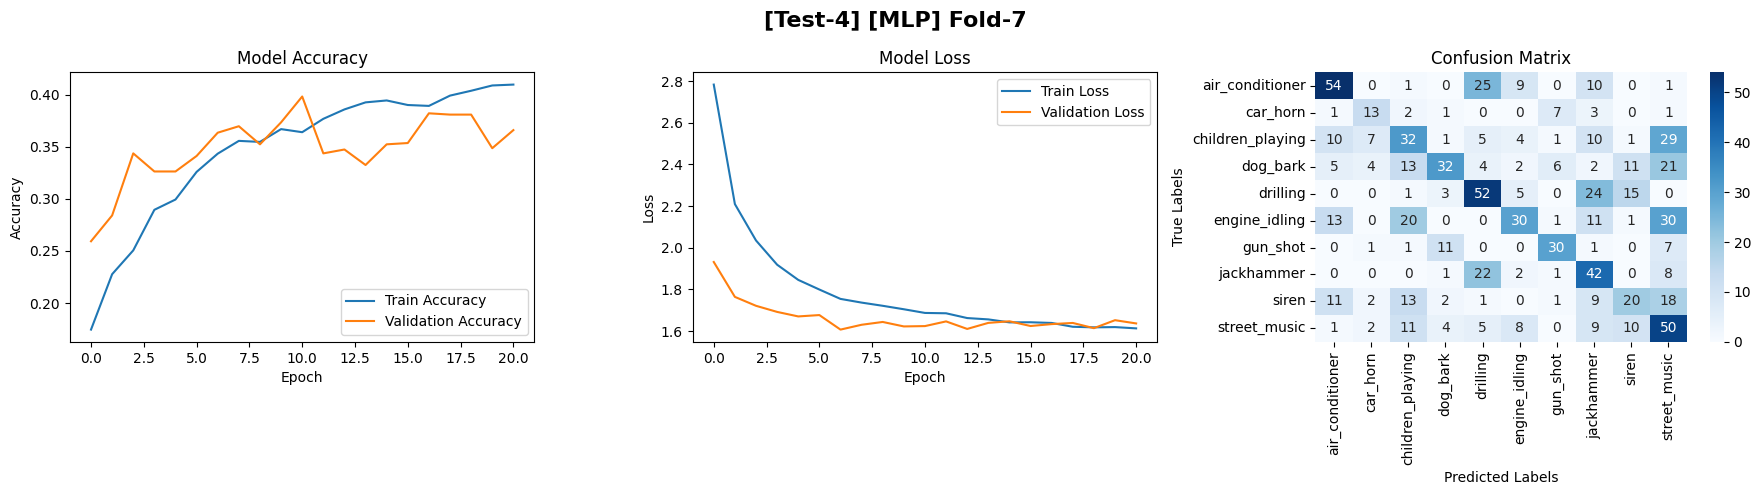

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


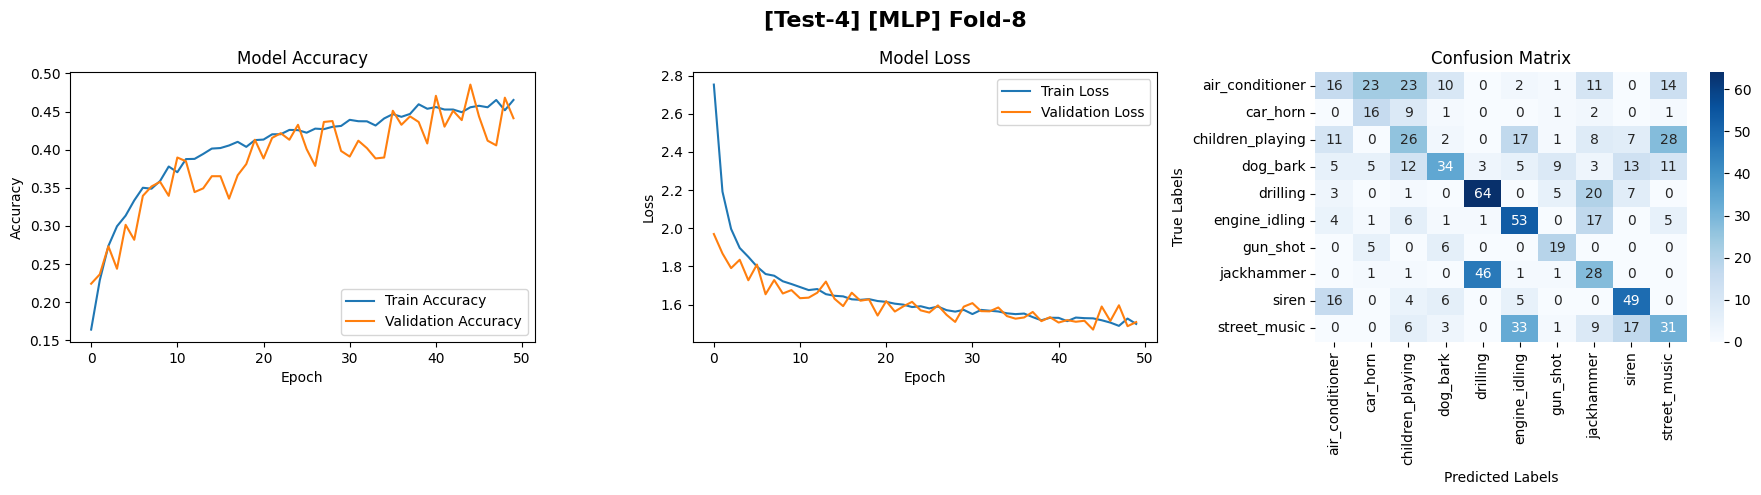

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


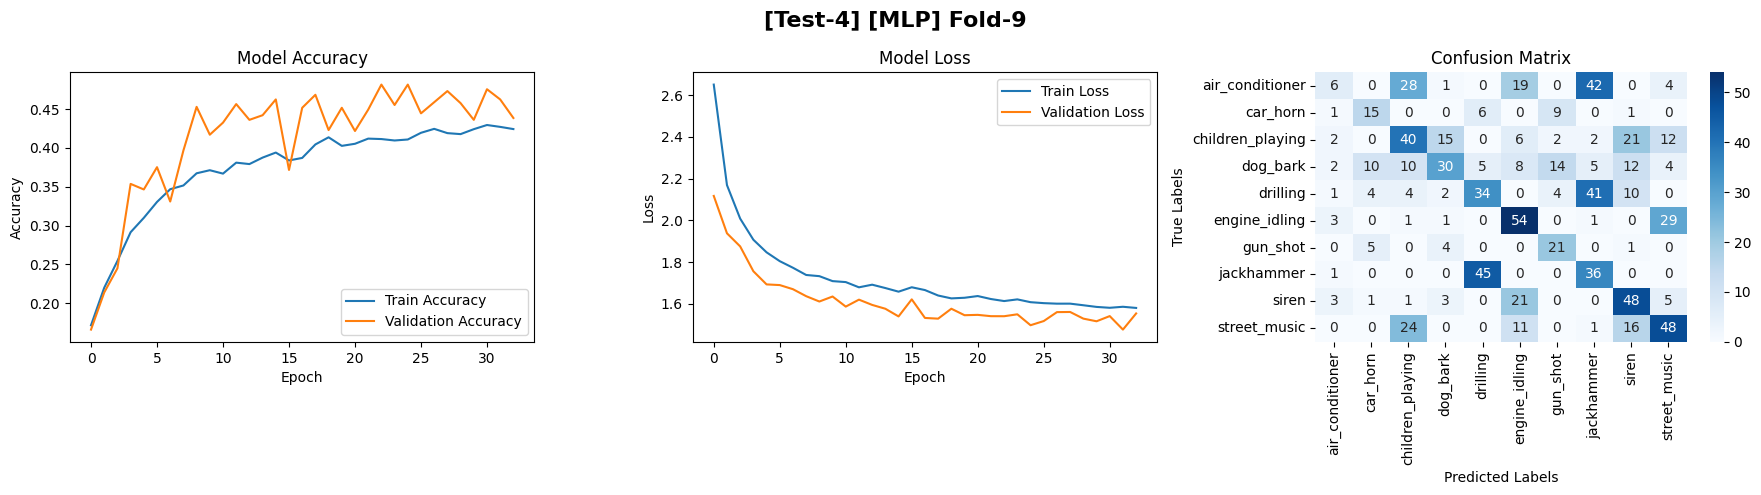

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


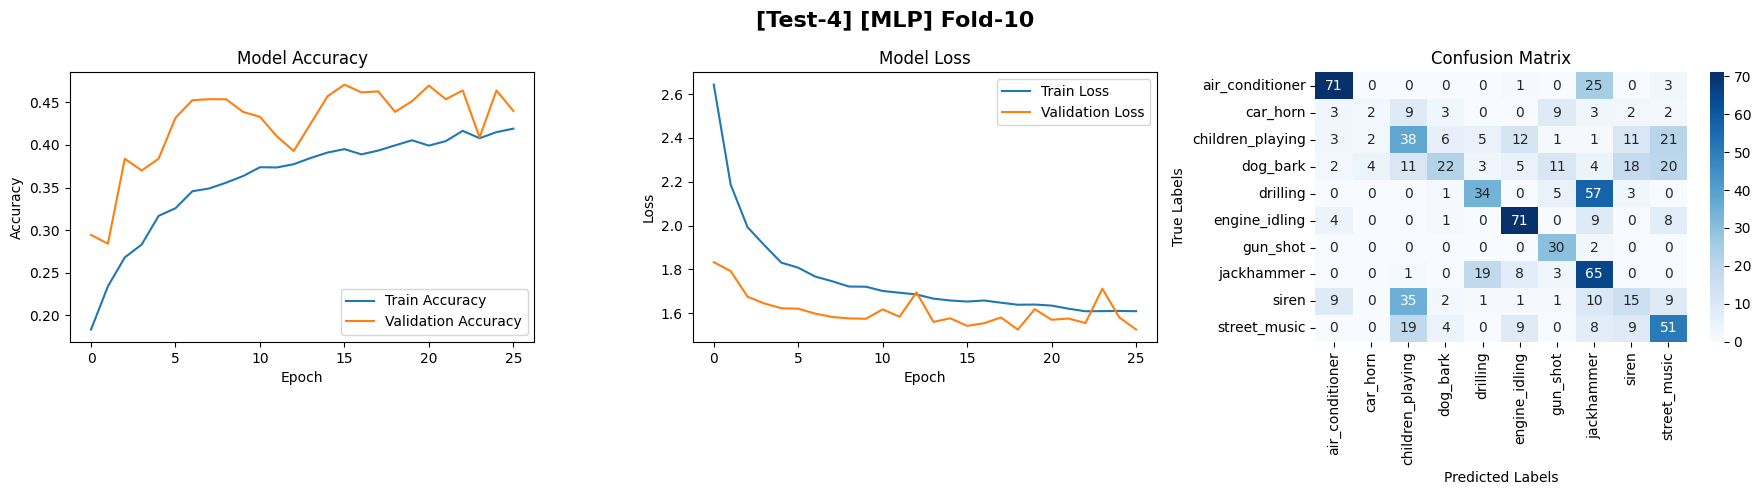

In [25]:
# Perform Cross Validation
_, histories, confusionMatrices = mlpDataManager.crossValidate(createModel=createMLP(input_shape=(255,), lr=0.001), numberFolds=10, epochs=50, callbacks=callbacks)

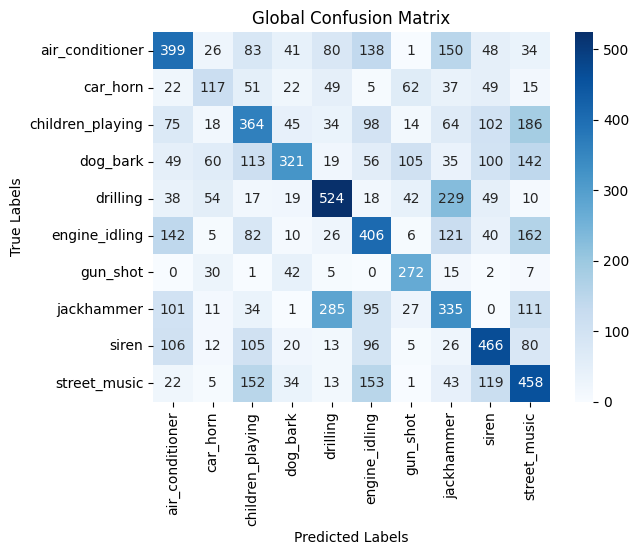

In [24]:
# Plot the Global Confusion Matrix
mlpDataManager.plotGlobalConfusionMatrix(confusionMatrices)

Em comparação com o segundo modelo, o resultados de algumas folds aparentam estabilizar, no entanto a **accuracy do modelo não supera aquelas dos modelos 1 e 3** e o **overfitting ainda é muito comum**.

---
### Dimensionality Reduction Visualization
---

---
#### Scatter Plot with PCA
---

C:\Users\2ndni\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


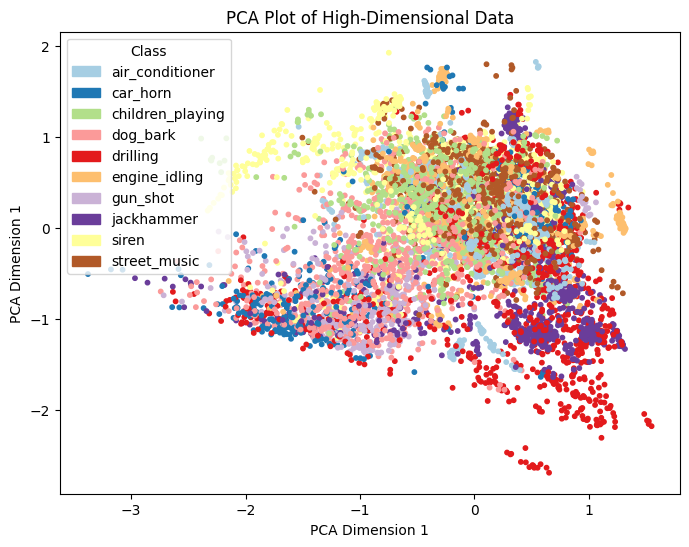

In [24]:
X, targets = mlpDataManager.getAllFolds()
plotScatterClass(X, targets)
del X, targets

While some classes show **moderate clustering**, the significant overlap between many indicates that **PCA in two dimensions cannot fully separate the classes**.

``Overlapping`` indicates that the **features contributing to the PCA** might not sufficiently **distinguish certain classes** or that the underlying data is **inherently similar** for some categories.

Classes like *drilling* (red) and *jackhammer* (purple) are **distributed more diffusely across the space**, this spread suggests **variability in the data for these classes**, which may arise from **diverse real-world scenarios**.

A few points appear **scattered outside dense regions**, which may **represent outliers** or **samples not well-captured** by the primary components. (ex: *dog_bark* (salmon))

---
#### Scatter Plot with t-SNE
---

C:\Users\2ndni\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


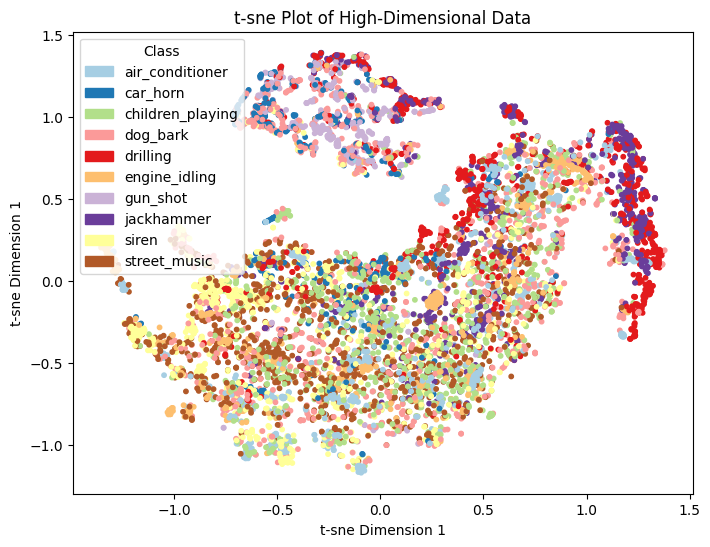

In [26]:
X, targets = mlpDataManager.getAllFolds()
plotScatterClass(X, targets, algorithm="t-sne")
del X, targets

Compared to PCA, **t-SNE emphasizes preserving local structures** and forming **tighter clusters**.

Many classes, such as *gun_shot* (light purple), *drilling* (red), and *jackhammer* (purple), form **distinct and compact clusters** in this plot. This indicates that **t-SNE captures separability better than PCA** for these categories.

Some **overlap remains between similar** or **noisy classes**, such as *children_playing* (green) and *street_music* (brown), especially in the **dense lower region** of the plot.
This could reflect **intrinsic similarities between these sounds** or **shared feature characteristics** in the **high-dimensional space**.